# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Discrete)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic Real-Time Bidding (RTB) dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead as EpsilonGreedyHead
from ofrl.policy import DiscreteSoftmaxHead as SoftmaxHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler
from ofrl.utils import MinMaxScaler


# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the RTB environment works.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe some feedback from the environment at each timestep, which includes the following.
  - timestep
  - remaining budget
  - impression level features (budget consumption rate, cost per mille of impressions, auction winning rate, reward) at the previous timestep
  - adjust rate (RL agent's decision making) at the previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_customize_env.ipynb).

In [9]:
# standardized environment for discrete action
env = gym.make("RTBEnv-discrete-v0")

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with the uniform random agent.

`SyntheticDataset` has the following arguments:
- `env`: RTB environment for RL defined in the previous section.
- `behavior_policy`: RL agent (or algorithm) used for the data collection.
- `maximum_step_per_episode`: Maximum number of timesteps in an episode.
- `action_meaning`: Dictionary which maps discrete action index into specific actions.
- `action_keys`: Name of the action variable at each dimension.
- `state_keys`: Name of the state variable at each dimension.
- `info_keys`: Dictionary containing of key and the type of info components.
- `random_state`: Random state.

For more about the data collection and visualization, please refer to [examples/quickstart/rtb_synthetic_data_collection.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [12]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2022-11-24 04:09.24 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20221124040924
2022-11-24 04:09.24 [debug    ] Building model...
2022-11-24 04:09.24 [debug    ] Model has been built.
2022-11-24 04:09.24 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20221124040924/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (7,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2022-11-24 04:09.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20221124040924/model_1000.pt
2022-11-24 04:09.26 [info     ] DoubleDQN_online_20221124040924: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0006391119956970215, 'time_environment_step': 0.0011666758060455322, 'time_step': 0.0018793754577636718, 'rollout_return': 14.028169014084508, 'evaluation': 14.3} step=1000
2022-11-24 04:09.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20221124040924/model_2000.pt
2022-11-24 04:09.34 [info     ] DoubleDQN_online_20221124040924: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0006009256839752198, 'time_environment_step': 0.0012014827728271484, 'time_sample_batch': 0.00016651487350463867, 'time_algorithm_update': 0.006054023504257202, 'loss': 51.65224489116669, 'time_step': 0.008141992568969726, 'rollout_return': 11.330985915492958, 'evaluation': 6.2} step=2000
2022-11-24 04:09.39 [info     ] Model parameters are save

In [ ]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [12]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

In [13]:
behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [14]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
    random_state=random_state,
)

In [15]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
logged_dataset = dataset.obtain_episodes(n_datasets=10, n_trajectories=10000, obtain_info=True)

[obtain_datasets]:   0%|          | 0/10 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
with open("logs/dataset_discrete_ddpn_10.pkl", "wb") as f:
    pickle.dump(logged_dataset, f)

In [17]:
with open("logs/dataset_discrete_ddpn_10.pkl", "rb") as f:
    logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rtb_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_basic.ipynb).

In [18]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import DiscreteCQL as CQL

In [19]:
# evaluation policies
cql_b1 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)
cql_b2 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)
cql_b3 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

algorithms = [cql_b1, cql_b2, cql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3"]

In [20]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [21]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

[learn_policies: logged_datasets]:   0%|          | 0/10 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-07 21:33.44 [debug    ] RandomIterator is selected.
2023-01-07 21:33.44 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213344
2023-01-07 21:33.44 [debug    ] Building models...
2023-01-07 21:33.44 [debug    ] Models have been built.
2023-01-07 21:33.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213344/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:34.20 [info     ] DiscreteCQL_20230107213344: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000200718355178833, 'time_algorithm_update': 0.003184112024307251, 'loss': 85.65595311393737, 'time_step': 0.0036010544538497926} step=10000
2023-01-07 21:34.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213344/model_10000.pt
2023-01-07 21:34.20 [debug    ] RandomIterator is selected.
2023-01-07 21:34.20 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213420
2023-01-07 21:34.20 [debug    ] Building models...
2023-01-07 21:34.20 [debug    ] Models have been built.
2023-01-07 21:34.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213420/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_max

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:34.55 [info     ] DiscreteCQL_20230107213420: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021315157413482667, 'time_algorithm_update': 0.002977500319480896, 'loss': 225.8309766365051, 'time_step': 0.003412646555900574} step=10000
2023-01-07 21:34.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213420/model_10000.pt
2023-01-07 21:34.55 [debug    ] RandomIterator is selected.
2023-01-07 21:34.55 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213455
2023-01-07 21:34.55 [debug    ] Building models...
2023-01-07 21:34.55 [debug    ] Models have been built.
2023-01-07 21:34.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213455/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:35.39 [info     ] DiscreteCQL_20230107213455: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021987190246582032, 'time_algorithm_update': 0.0038525417089462282, 'loss': 106.38383310656548, 'time_step': 0.00428610224723816} step=10000
2023-01-07 21:35.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213455/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-07 21:35.39 [debug    ] RandomIterator is selected.
2023-01-07 21:35.39 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213539
2023-01-07 21:35.39 [warning  ] Skip building models since they're already built.
2023-01-07 21:35.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213539/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:36.16 [info     ] DiscreteCQL_20230107213539: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0002196391820907593, 'time_algorithm_update': 0.0031993292331695556, 'loss': 25.86580548654795, 'time_step': 0.0036205474615097046} step=10000
2023-01-07 21:36.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213539/model_10000.pt
2023-01-07 21:36.16 [debug    ] RandomIterator is selected.
2023-01-07 21:36.16 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213616
2023-01-07 21:36.16 [warning  ] Skip building models since they're already built.
2023-01-07 21:36.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213616/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:36.48 [info     ] DiscreteCQL_20230107213616: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021258907318115233, 'time_algorithm_update': 0.00277468466758728, 'loss': 70.9920395576477, 'time_step': 0.003194642210006714} step=10000
2023-01-07 21:36.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213616/model_10000.pt
2023-01-07 21:36.48 [debug    ] RandomIterator is selected.
2023-01-07 21:36.48 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213648
2023-01-07 21:36.48 [warning  ] Skip building models since they're already built.
2023-01-07 21:36.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213648/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:37.24 [info     ] DiscreteCQL_20230107213648: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00020744156837463378, 'time_algorithm_update': 0.003140683698654175, 'loss': 3.9472388387680053, 'time_step': 0.0035407612085342406} step=10000
2023-01-07 21:37.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213648/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-07 21:37.25 [debug    ] RandomIterator is selected.
2023-01-07 21:37.25 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213725
2023-01-07 21:37.25 [warning  ] Skip building models since they're already built.
2023-01-07 21:37.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213725/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:38.03 [info     ] DiscreteCQL_20230107213725: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021328203678131104, 'time_algorithm_update': 0.003358238363265991, 'loss': 20.469412063860894, 'time_step': 0.00378671178817749} step=10000
2023-01-07 21:38.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213725/model_10000.pt
2023-01-07 21:38.03 [debug    ] RandomIterator is selected.
2023-01-07 21:38.03 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213803
2023-01-07 21:38.03 [warning  ] Skip building models since they're already built.
2023-01-07 21:38.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213803/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:38.38 [info     ] DiscreteCQL_20230107213803: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021661083698272705, 'time_algorithm_update': 0.0030086959838867187, 'loss': 49.378538370800015, 'time_step': 0.003444231128692627} step=10000
2023-01-07 21:38.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213803/model_10000.pt
2023-01-07 21:38.38 [debug    ] RandomIterator is selected.
2023-01-07 21:38.38 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213838
2023-01-07 21:38.38 [warning  ] Skip building models since they're already built.
2023-01-07 21:38.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213838/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:39.15 [info     ] DiscreteCQL_20230107213838: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00022047209739685058, 'time_algorithm_update': 0.003179069995880127, 'loss': 3.925992963027954, 'time_step': 0.0036126290798187254} step=10000
2023-01-07 21:39.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213838/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-07 21:39.16 [debug    ] RandomIterator is selected.
2023-01-07 21:39.16 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213916
2023-01-07 21:39.16 [warning  ] Skip building models since they're already built.
2023-01-07 21:39.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213916/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:39.58 [info     ] DiscreteCQL_20230107213916: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00023311691284179687, 'time_algorithm_update': 0.00371985981464386, 'loss': 14.426866175103187, 'time_step': 0.0041741619110107426} step=10000
2023-01-07 21:39.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213916/model_10000.pt
2023-01-07 21:39.58 [debug    ] RandomIterator is selected.
2023-01-07 21:39.58 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107213958
2023-01-07 21:39.58 [warning  ] Skip building models since they're already built.
2023-01-07 21:39.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213958/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:40.39 [info     ] DiscreteCQL_20230107213958: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00023592538833618165, 'time_algorithm_update': 0.0035565054178237914, 'loss': 32.8277756169796, 'time_step': 0.004025008392333985} step=10000
2023-01-07 21:40.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107213958/model_10000.pt
2023-01-07 21:40.39 [debug    ] RandomIterator is selected.
2023-01-07 21:40.39 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214039
2023-01-07 21:40.39 [warning  ] Skip building models since they're already built.
2023-01-07 21:40.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214039/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:41.20 [info     ] DiscreteCQL_20230107214039: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00023372058868408204, 'time_algorithm_update': 0.0035216272830963136, 'loss': 3.9346045517921446, 'time_step': 0.003976431727409363} step=10000
2023-01-07 21:41.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214039/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-07 21:41.20 [debug    ] RandomIterator is selected.
2023-01-07 21:41.20 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214120
2023-01-07 21:41.20 [warning  ] Skip building models since they're already built.
2023-01-07 21:41.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214120/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:42.02 [info     ] DiscreteCQL_20230107214120: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00023422262668609619, 'time_algorithm_update': 0.0036899667024612426, 'loss': 9.10094832341671, 'time_step': 0.004140026378631592} step=10000
2023-01-07 21:42.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214120/model_10000.pt
2023-01-07 21:42.02 [debug    ] RandomIterator is selected.
2023-01-07 21:42.02 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214202
2023-01-07 21:42.02 [warning  ] Skip building models since they're already built.
2023-01-07 21:42.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214202/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:42.38 [info     ] DiscreteCQL_20230107214202: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0002244682550430298, 'time_algorithm_update': 0.003052121043205261, 'loss': 20.555389423894884, 'time_step': 0.003492263627052307} step=10000
2023-01-07 21:42.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214202/model_10000.pt
2023-01-07 21:42.38 [debug    ] RandomIterator is selected.
2023-01-07 21:42.38 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214238
2023-01-07 21:42.38 [warning  ] Skip building models since they're already built.
2023-01-07 21:42.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214238/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:43.15 [info     ] DiscreteCQL_20230107214238: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00023059687614440918, 'time_algorithm_update': 0.0031899239540100098, 'loss': 3.9334804471254348, 'time_step': 0.0036232971906661987} step=10000
2023-01-07 21:43.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214238/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-07 21:43.15 [debug    ] RandomIterator is selected.
2023-01-07 21:43.15 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214315
2023-01-07 21:43.15 [warning  ] Skip building models since they're already built.
2023-01-07 21:43.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214315/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:43.51 [info     ] DiscreteCQL_20230107214315: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0002185599088668823, 'time_algorithm_update': 0.003046687078475952, 'loss': 6.729044633507729, 'time_step': 0.003473718237876892} step=10000
2023-01-07 21:43.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214315/model_10000.pt
2023-01-07 21:43.51 [debug    ] RandomIterator is selected.
2023-01-07 21:43.51 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214351
2023-01-07 21:43.51 [warning  ] Skip building models since they're already built.
2023-01-07 21:43.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214351/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_r

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:44.21 [info     ] DiscreteCQL_20230107214351: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0002079212427139282, 'time_algorithm_update': 0.0025329758405685425, 'loss': 14.135220115423202, 'time_step': 0.0029323498487472534} step=10000
2023-01-07 21:44.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214351/model_10000.pt
2023-01-07 21:44.21 [debug    ] RandomIterator is selected.
2023-01-07 21:44.21 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214421
2023-01-07 21:44.21 [warning  ] Skip building models since they're already built.
2023-01-07 21:44.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214421/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:44.55 [info     ] DiscreteCQL_20230107214421: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00020752060413360595, 'time_algorithm_update': 0.0030232897520065306, 'loss': 3.6694872896552084, 'time_step': 0.003419104790687561} step=10000
2023-01-07 21:44.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214421/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-07 21:44.56 [debug    ] RandomIterator is selected.
2023-01-07 21:44.56 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214456
2023-01-07 21:44.56 [warning  ] Skip building models since they're already built.
2023-01-07 21:44.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214456/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:45.30 [info     ] DiscreteCQL_20230107214456: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0002035189151763916, 'time_algorithm_update': 0.0029149903059005737, 'loss': 5.012068399655819, 'time_step': 0.0033247395753860476} step=10000
2023-01-07 21:45.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214456/model_10000.pt
2023-01-07 21:45.30 [debug    ] RandomIterator is selected.
2023-01-07 21:45.30 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214530
2023-01-07 21:45.30 [warning  ] Skip building models since they're already built.
2023-01-07 21:45.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214530/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:46.01 [info     ] DiscreteCQL_20230107214530: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021116342544555663, 'time_algorithm_update': 0.0026638566255569457, 'loss': 9.833220265722275, 'time_step': 0.0030784928798675538} step=10000
2023-01-07 21:46.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214530/model_10000.pt
2023-01-07 21:46.01 [debug    ] RandomIterator is selected.
2023-01-07 21:46.01 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214601
2023-01-07 21:46.01 [warning  ] Skip building models since they're already built.
2023-01-07 21:46.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214601/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:46.35 [info     ] DiscreteCQL_20230107214601: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00020801897048950197, 'time_algorithm_update': 0.0029794719457626345, 'loss': 3.072805191004276, 'time_step': 0.0033803388833999635} step=10000
2023-01-07 21:46.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214601/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-07 21:46.36 [debug    ] RandomIterator is selected.
2023-01-07 21:46.36 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214636
2023-01-07 21:46.36 [warning  ] Skip building models since they're already built.
2023-01-07 21:46.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214636/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:47.12 [info     ] DiscreteCQL_20230107214636: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0002124467134475708, 'time_algorithm_update': 0.00311673150062561, 'loss': 4.073691690993309, 'time_step': 0.0035373935222625733} step=10000
2023-01-07 21:47.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214636/model_10000.pt
2023-01-07 21:47.12 [debug    ] RandomIterator is selected.
2023-01-07 21:47.12 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214712
2023-01-07 21:47.12 [warning  ] Skip building models since they're already built.
2023-01-07 21:47.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214712/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_r

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:47.45 [info     ] DiscreteCQL_20230107214712: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021283514499664306, 'time_algorithm_update': 0.0027717382192611693, 'loss': 7.008911564898491, 'time_step': 0.003207773160934448} step=10000
2023-01-07 21:47.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214712/model_10000.pt
2023-01-07 21:47.45 [debug    ] RandomIterator is selected.
2023-01-07 21:47.45 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214745
2023-01-07 21:47.45 [warning  ] Skip building models since they're already built.
2023-01-07 21:47.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214745/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:48.24 [info     ] DiscreteCQL_20230107214745: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0002176520824432373, 'time_algorithm_update': 0.0034575445890426635, 'loss': 2.56030806568861, 'time_step': 0.0038936704397201536} step=10000
2023-01-07 21:48.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214745/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-07 21:48.25 [debug    ] RandomIterator is selected.
2023-01-07 21:48.25 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214825
2023-01-07 21:48.25 [warning  ] Skip building models since they're already built.
2023-01-07 21:48.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214825/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:49.04 [info     ] DiscreteCQL_20230107214825: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021755075454711915, 'time_algorithm_update': 0.0034871699571609495, 'loss': 3.0640697892308237, 'time_step': 0.003904169273376465} step=10000
2023-01-07 21:49.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214825/model_10000.pt
2023-01-07 21:49.04 [debug    ] RandomIterator is selected.
2023-01-07 21:49.04 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214904
2023-01-07 21:49.04 [warning  ] Skip building models since they're already built.
2023-01-07 21:49.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214904/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:49.39 [info     ] DiscreteCQL_20230107214904: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021744246482849122, 'time_algorithm_update': 0.0029855061769485476, 'loss': 5.429496839737892, 'time_step': 0.0034054136991500854} step=10000
2023-01-07 21:49.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214904/model_10000.pt
2023-01-07 21:49.39 [debug    ] RandomIterator is selected.
2023-01-07 21:49.39 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107214939
2023-01-07 21:49.39 [warning  ] Skip building models since they're already built.
2023-01-07 21:49.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214939/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:50.20 [info     ] DiscreteCQL_20230107214939: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0002218543291091919, 'time_algorithm_update': 0.0035849879264831545, 'loss': 2.4624974981665613, 'time_step': 0.004011722302436829} step=10000
2023-01-07 21:50.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107214939/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-01-07 21:50.20 [debug    ] RandomIterator is selected.
2023-01-07 21:50.20 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107215020
2023-01-07 21:50.20 [warning  ] Skip building models since they're already built.
2023-01-07 21:50.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107215020/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:50.59 [info     ] DiscreteCQL_20230107215020: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00021045477390289308, 'time_algorithm_update': 0.0033910169363021853, 'loss': 2.6985599334836006, 'time_step': 0.003797038269042969} step=10000
2023-01-07 21:50.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107215020/model_10000.pt
2023-01-07 21:50.59 [debug    ] RandomIterator is selected.
2023-01-07 21:50.59 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107215059
2023-01-07 21:50.59 [warning  ] Skip building models since they're already built.
2023-01-07 21:50.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107215059/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:51.32 [info     ] DiscreteCQL_20230107215059: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00020771114826202393, 'time_algorithm_update': 0.0028263699769973754, 'loss': 3.859916599071026, 'time_step': 0.0032270161628723142} step=10000
2023-01-07 21:51.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107215059/model_10000.pt
2023-01-07 21:51.32 [debug    ] RandomIterator is selected.
2023-01-07 21:51.32 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230107215132
2023-01-07 21:51.32 [warning  ] Skip building models since they're already built.
2023-01-07 21:51.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230107215132/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:52.08 [info     ] DiscreteCQL_20230107215132: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0002141690969467163, 'time_algorithm_update': 0.0031339097023010253, 'loss': 2.4479409897565843, 'time_step': 0.0035432787656784056} step=10000
2023-01-07 21:52.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230107215132/model_10000.pt


In [22]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [23]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [24]:
# policy wrapper
policy_wrappers = {
    "eps_00": (
        EpsilonGreedyHead, {
            "epsilon": 0.0,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_03": (
        EpsilonGreedyHead, {
            "epsilon": 0.3,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_07": (
        EpsilonGreedyHead, {
            "epsilon": 0.7,
            "n_actions": env.action_space.n,
        }
    ),
    "softmax": (
        SoftmaxHead, {
            "tau": 1.0,
            "n_actions": env.action_space.n,
        }
    )
}

In [25]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [26]:
[eval_policy.name for eval_policy in eval_policies[0]]

['cql_b1_eps_00',
 'cql_b1_eps_03',
 'cql_b1_eps_07',
 'cql_b1_softmax',
 'cql_b2_eps_00',
 'cql_b2_eps_03',
 'cql_b2_eps_07',
 'cql_b2_softmax',
 'cql_b3_eps_00',
 'cql_b3_eps_03',
 'cql_b3_eps_07',
 'cql_b3_softmax']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [27]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [28]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=logged_dataset.get(0)["state"].min(axis=0),
        maximum=logged_dataset.get(0)["state"].max(axis=0),
    ),
)

In [94]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[collect input data: datasets]:   0%|          | 0/10 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:50.58 [debug    ] RoundIterator is selected.
2023-01-08 06:50.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065058
2023-01-08 06:50.58 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.58 [debug    ] Building models...
2023-01-08 06:50.58 [debug    ] Models have been built.
2023-01-08 06:50.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065058/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.59 [info     ] DiscreteFQE_20230108065058: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001732121195111956, 'time_algorithm_update': 0.0021904604775565013, 'loss': 1.7947786670071737, 'time_step': 0.0024283014025006976} step=700
2023-01-08 06:50.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065058/model_700.pt
2023-01-08 06:50.59 [debug    ] RoundIterator is selected.
2023-01-08 06:50.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065059
2023-01-08 06:50.59 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.59 [debug    ] Building models...
2023-01-08 06:50.59 [debug    ] Models have been built.
2023-01-08 06:50.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065059/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.01 [info     ] DiscreteFQE_20230108065059: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018103224890572684, 'time_algorithm_update': 0.0024432570593697685, 'loss': 1.763223849620138, 'time_step': 0.002690371785845075} step=700
2023-01-08 06:51.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065059/model_700.pt
2023-01-08 06:51.01 [debug    ] RoundIterator is selected.
2023-01-08 06:51.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065101
2023-01-08 06:51.01 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.01 [debug    ] Building models...
2023-01-08 06:51.01 [debug    ] Models have been built.
2023-01-08 06:51.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065101/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.03 [info     ] DiscreteFQE_20230108065101: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.000167499269757952, 'time_algorithm_update': 0.0024282302175249373, 'loss': 1.7269487254960196, 'time_step': 0.002671510492052351} step=700
2023-01-08 06:51.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065101/model_700.pt
2023-01-08 06:51.03 [debug    ] RoundIterator is selected.
2023-01-08 06:51.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065103
2023-01-08 06:51.03 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.03 [debug    ] Building models...
2023-01-08 06:51.03 [debug    ] Models have been built.
2023-01-08 06:51.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065103/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.05 [info     ] DiscreteFQE_20230108065103: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015988962990897042, 'time_algorithm_update': 0.0018166375160217285, 'loss': 1.805916440997805, 'time_step': 0.002036749976021903} step=700
2023-01-08 06:51.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065103/model_700.pt
2023-01-08 06:51.05 [debug    ] RoundIterator is selected.
2023-01-08 06:51.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065105
2023-01-08 06:51.05 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.05 [debug    ] Building models...
2023-01-08 06:51.05 [debug    ] Models have been built.
2023-01-08 06:51.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065105/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.06 [info     ] DiscreteFQE_20230108065105: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015826259340558733, 'time_algorithm_update': 0.0017747480528695243, 'loss': 1.786461240053177, 'time_step': 0.0019984470094953264} step=700
2023-01-08 06:51.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065105/model_700.pt
2023-01-08 06:51.06 [debug    ] RoundIterator is selected.
2023-01-08 06:51.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065106
2023-01-08 06:51.06 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.06 [debug    ] Building models...
2023-01-08 06:51.06 [debug    ] Models have been built.
2023-01-08 06:51.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065106/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.08 [info     ] DiscreteFQE_20230108065106: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014518533434186662, 'time_algorithm_update': 0.0016425115721566336, 'loss': 1.862776859998703, 'time_step': 0.0018462647710527692} step=700
2023-01-08 06:51.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065106/model_700.pt
2023-01-08 06:51.08 [debug    ] RoundIterator is selected.
2023-01-08 06:51.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065108
2023-01-08 06:51.08 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.08 [debug    ] Building models...
2023-01-08 06:51.08 [debug    ] Models have been built.
2023-01-08 06:51.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065108/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.09 [info     ] DiscreteFQE_20230108065108: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015199695314679828, 'time_algorithm_update': 0.0017147510392325266, 'loss': 1.7183725876467568, 'time_step': 0.00192659854888916} step=700
2023-01-08 06:51.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065108/model_700.pt
2023-01-08 06:51.09 [debug    ] RoundIterator is selected.
2023-01-08 06:51.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065109
2023-01-08 06:51.09 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.09 [debug    ] Building models...
2023-01-08 06:51.09 [debug    ] Models have been built.
2023-01-08 06:51.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065109/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.10 [info     ] DiscreteFQE_20230108065109: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015713044575282507, 'time_algorithm_update': 0.0017529606819152832, 'loss': 1.7746931062425886, 'time_step': 0.001970268658229283} step=700
2023-01-08 06:51.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065109/model_700.pt
2023-01-08 06:51.10 [debug    ] RoundIterator is selected.
2023-01-08 06:51.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065110
2023-01-08 06:51.10 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.10 [debug    ] Building models...
2023-01-08 06:51.11 [debug    ] Models have been built.
2023-01-08 06:51.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065110/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.12 [info     ] DiscreteFQE_20230108065110: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001754941259111677, 'time_algorithm_update': 0.0020556044578552246, 'loss': 1.6605054237161363, 'time_step': 0.0023039933613368444} step=700
2023-01-08 06:51.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065110/model_700.pt
2023-01-08 06:51.12 [debug    ] RoundIterator is selected.
2023-01-08 06:51.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065112
2023-01-08 06:51.12 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.12 [debug    ] Building models...
2023-01-08 06:51.12 [debug    ] Models have been built.
2023-01-08 06:51.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065112/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.14 [info     ] DiscreteFQE_20230108065112: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001581437247140067, 'time_algorithm_update': 0.0018122516359601701, 'loss': 1.696455193076815, 'time_step': 0.002032226834978376} step=700
2023-01-08 06:51.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065112/model_700.pt
2023-01-08 06:51.14 [debug    ] RoundIterator is selected.
2023-01-08 06:51.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065114
2023-01-08 06:51.14 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.14 [debug    ] Building models...
2023-01-08 06:51.14 [debug    ] Models have been built.
2023-01-08 06:51.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065114/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.15 [info     ] DiscreteFQE_20230108065114: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015734876905168805, 'time_algorithm_update': 0.001766526358468192, 'loss': 1.8395480150835855, 'time_step': 0.0019883864266531806} step=700
2023-01-08 06:51.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065114/model_700.pt
2023-01-08 06:51.15 [debug    ] RoundIterator is selected.
2023-01-08 06:51.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065115
2023-01-08 06:51.15 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.15 [debug    ] Building models...
2023-01-08 06:51.15 [debug    ] Models have been built.
2023-01-08 06:51.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065115/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.17 [info     ] DiscreteFQE_20230108065115: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001803483281816755, 'time_algorithm_update': 0.002067788669041225, 'loss': 1.7570863361018045, 'time_step': 0.0023223188945225306} step=700
2023-01-08 06:51.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065115/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:51.59 [debug    ] RoundIterator is selected.
2023-01-08 06:51.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065159
2023-01-08 06:51.59 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.59 [debug    ] Building models...
2023-01-08 06:51.59 [debug    ] Models have been built.
2023-01-08 06:51.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065159/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.01 [info     ] DiscreteFQE_20230108065159: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015259197780064174, 'time_algorithm_update': 0.0017836989675249371, 'loss': 1.7909218645095826, 'time_step': 0.0019979381561279295} step=700
2023-01-08 06:52.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065159/model_700.pt
2023-01-08 06:52.01 [debug    ] RoundIterator is selected.
2023-01-08 06:52.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065201
2023-01-08 06:52.01 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.01 [debug    ] Building models...
2023-01-08 06:52.01 [debug    ] Models have been built.
2023-01-08 06:52.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065201/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.02 [info     ] DiscreteFQE_20230108065201: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001574880736214774, 'time_algorithm_update': 0.0019182773998805455, 'loss': 1.760049193246024, 'time_step': 0.002141458647591727} step=700
2023-01-08 06:52.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065201/model_700.pt
2023-01-08 06:52.02 [debug    ] RoundIterator is selected.
2023-01-08 06:52.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065202
2023-01-08 06:52.02 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.02 [debug    ] Building models...
2023-01-08 06:52.02 [debug    ] Models have been built.
2023-01-08 06:52.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065202/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.04 [info     ] DiscreteFQE_20230108065202: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015063626425606863, 'time_algorithm_update': 0.0017664950234549386, 'loss': 1.793262460912977, 'time_step': 0.0019768006461007253} step=700
2023-01-08 06:52.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065202/model_700.pt
2023-01-08 06:52.04 [debug    ] RoundIterator is selected.
2023-01-08 06:52.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065204
2023-01-08 06:52.04 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.04 [debug    ] Building models...
2023-01-08 06:52.04 [debug    ] Models have been built.
2023-01-08 06:52.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065204/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.05 [info     ] DiscreteFQE_20230108065204: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014591591698782783, 'time_algorithm_update': 0.0017128195081438336, 'loss': 1.7961821513516563, 'time_step': 0.0019121953419276646} step=700
2023-01-08 06:52.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065204/model_700.pt
2023-01-08 06:52.05 [debug    ] RoundIterator is selected.
2023-01-08 06:52.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065205
2023-01-08 06:52.05 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.05 [debug    ] Building models...
2023-01-08 06:52.05 [debug    ] Models have been built.
2023-01-08 06:52.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065205/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.07 [info     ] DiscreteFQE_20230108065205: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017139911651611328, 'time_algorithm_update': 0.0019760033062526158, 'loss': 1.783583253792354, 'time_step': 0.002212203230176653} step=700
2023-01-08 06:52.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065205/model_700.pt
2023-01-08 06:52.07 [debug    ] RoundIterator is selected.
2023-01-08 06:52.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065207
2023-01-08 06:52.07 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.07 [debug    ] Building models...
2023-01-08 06:52.07 [debug    ] Models have been built.
2023-01-08 06:52.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065207/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.09 [info     ] DiscreteFQE_20230108065207: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016491344996861048, 'time_algorithm_update': 0.0018932196072169712, 'loss': 1.7039920157194137, 'time_step': 0.0021246208463396345} step=700
2023-01-08 06:52.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065207/model_700.pt
2023-01-08 06:52.09 [debug    ] RoundIterator is selected.
2023-01-08 06:52.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065209
2023-01-08 06:52.09 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.09 [debug    ] Building models...
2023-01-08 06:52.09 [debug    ] Models have been built.
2023-01-08 06:52.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065209/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.10 [info     ] DiscreteFQE_20230108065209: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016084296362740654, 'time_algorithm_update': 0.0018192921366010394, 'loss': 1.621364557317325, 'time_step': 0.0020425735201154436} step=700
2023-01-08 06:52.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065209/model_700.pt
2023-01-08 06:52.10 [debug    ] RoundIterator is selected.
2023-01-08 06:52.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065210
2023-01-08 06:52.10 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.10 [debug    ] Building models...
2023-01-08 06:52.10 [debug    ] Models have been built.
2023-01-08 06:52.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065210/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.12 [info     ] DiscreteFQE_20230108065210: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001857590675354004, 'time_algorithm_update': 0.002081186090196882, 'loss': 1.7383974412509373, 'time_step': 0.0023434560639517647} step=700
2023-01-08 06:52.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065210/model_700.pt
2023-01-08 06:52.12 [debug    ] RoundIterator is selected.
2023-01-08 06:52.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065212
2023-01-08 06:52.12 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.12 [debug    ] Building models...
2023-01-08 06:52.12 [debug    ] Models have been built.
2023-01-08 06:52.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065212/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.14 [info     ] DiscreteFQE_20230108065212: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017151560102190291, 'time_algorithm_update': 0.002054023402077811, 'loss': 1.713879965203149, 'time_step': 0.0022931514467511857} step=700
2023-01-08 06:52.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065212/model_700.pt
2023-01-08 06:52.14 [debug    ] RoundIterator is selected.
2023-01-08 06:52.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065214
2023-01-08 06:52.14 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.14 [debug    ] Building models...
2023-01-08 06:52.14 [debug    ] Models have been built.
2023-01-08 06:52.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065214/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.15 [info     ] DiscreteFQE_20230108065214: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017271927424839564, 'time_algorithm_update': 0.001991668428693499, 'loss': 1.739889383997236, 'time_step': 0.0022309207916259765} step=700
2023-01-08 06:52.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065214/model_700.pt
2023-01-08 06:52.15 [debug    ] RoundIterator is selected.
2023-01-08 06:52.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065215
2023-01-08 06:52.15 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.15 [debug    ] Building models...
2023-01-08 06:52.15 [debug    ] Models have been built.
2023-01-08 06:52.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065215/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.17 [info     ] DiscreteFQE_20230108065215: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016743557793753486, 'time_algorithm_update': 0.0019260478019714356, 'loss': 1.7067990117413656, 'time_step': 0.0021570754051208497} step=700
2023-01-08 06:52.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065215/model_700.pt
2023-01-08 06:52.17 [debug    ] RoundIterator is selected.
2023-01-08 06:52.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065217
2023-01-08 06:52.17 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:52.17 [debug    ] Building models...
2023-01-08 06:52.17 [debug    ] Models have been built.
2023-01-08 06:52.17 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065217/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:52.18 [info     ] DiscreteFQE_20230108065217: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001563641003199986, 'time_algorithm_update': 0.0018205056871686662, 'loss': 1.7422971712691444, 'time_step': 0.002039806842803955} step=700
2023-01-08 06:52.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065217/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:53.03 [debug    ] RoundIterator is selected.
2023-01-08 06:53.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065303
2023-01-08 06:53.03 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.03 [debug    ] Building models...
2023-01-08 06:53.03 [debug    ] Models have been built.
2023-01-08 06:53.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065303/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.04 [info     ] DiscreteFQE_20230108065303: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016254288809640068, 'time_algorithm_update': 0.0018792830194745746, 'loss': 1.6444177651405334, 'time_step': 0.0021036546570914133} step=700
2023-01-08 06:53.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065303/model_700.pt
2023-01-08 06:53.04 [debug    ] RoundIterator is selected.
2023-01-08 06:53.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065304
2023-01-08 06:53.04 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.04 [debug    ] Building models...
2023-01-08 06:53.04 [debug    ] Models have been built.
2023-01-08 06:53.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065304/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.06 [info     ] DiscreteFQE_20230108065304: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015773705073765347, 'time_algorithm_update': 0.001924950054713658, 'loss': 1.7154000626291548, 'time_step': 0.002141730785369873} step=700
2023-01-08 06:53.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065304/model_700.pt
2023-01-08 06:53.06 [debug    ] RoundIterator is selected.
2023-01-08 06:53.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065306
2023-01-08 06:53.06 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.06 [debug    ] Building models...
2023-01-08 06:53.06 [debug    ] Models have been built.
2023-01-08 06:53.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065306/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.08 [info     ] DiscreteFQE_20230108065306: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015721218926565986, 'time_algorithm_update': 0.0018133473396301268, 'loss': 1.7729819554941995, 'time_step': 0.0020286808695111954} step=700
2023-01-08 06:53.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065306/model_700.pt
2023-01-08 06:53.08 [debug    ] RoundIterator is selected.
2023-01-08 06:53.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065308
2023-01-08 06:53.08 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.08 [debug    ] Building models...
2023-01-08 06:53.08 [debug    ] Models have been built.
2023-01-08 06:53.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065308/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.09 [info     ] DiscreteFQE_20230108065308: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015951224735804965, 'time_algorithm_update': 0.001868234361921038, 'loss': 1.747246631383896, 'time_step': 0.002088345459529332} step=700
2023-01-08 06:53.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065308/model_700.pt
2023-01-08 06:53.09 [debug    ] RoundIterator is selected.
2023-01-08 06:53.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065309
2023-01-08 06:53.09 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.09 [debug    ] Building models...
2023-01-08 06:53.09 [debug    ] Models have been built.
2023-01-08 06:53.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065309/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.11 [info     ] DiscreteFQE_20230108065309: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015546321868896483, 'time_algorithm_update': 0.0017855634008135115, 'loss': 1.7896948896135603, 'time_step': 0.00199946403503418} step=700
2023-01-08 06:53.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065309/model_700.pt
2023-01-08 06:53.11 [debug    ] RoundIterator is selected.
2023-01-08 06:53.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065311
2023-01-08 06:53.11 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.11 [debug    ] Building models...
2023-01-08 06:53.11 [debug    ] Models have been built.
2023-01-08 06:53.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065311/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.12 [info     ] DiscreteFQE_20230108065311: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001584253992353167, 'time_algorithm_update': 0.001834380967276437, 'loss': 1.7743367564678192, 'time_step': 0.0020552808897835867} step=700
2023-01-08 06:53.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065311/model_700.pt
2023-01-08 06:53.12 [debug    ] RoundIterator is selected.
2023-01-08 06:53.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065312
2023-01-08 06:53.12 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.12 [debug    ] Building models...
2023-01-08 06:53.12 [debug    ] Models have been built.
2023-01-08 06:53.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065312/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.14 [info     ] DiscreteFQE_20230108065312: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001633943830217634, 'time_algorithm_update': 0.0018168987546648297, 'loss': 1.7651183361666543, 'time_step': 0.0020476412773132325} step=700
2023-01-08 06:53.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065312/model_700.pt
2023-01-08 06:53.14 [debug    ] RoundIterator is selected.
2023-01-08 06:53.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065314
2023-01-08 06:53.14 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.14 [debug    ] Building models...
2023-01-08 06:53.14 [debug    ] Models have been built.
2023-01-08 06:53.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065314/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.15 [info     ] DiscreteFQE_20230108065314: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016740219933646065, 'time_algorithm_update': 0.0019045543670654296, 'loss': 1.6721931591204235, 'time_step': 0.002140899385724749} step=700
2023-01-08 06:53.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065314/model_700.pt
2023-01-08 06:53.15 [debug    ] RoundIterator is selected.
2023-01-08 06:53.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065315
2023-01-08 06:53.15 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.15 [debug    ] Building models...
2023-01-08 06:53.15 [debug    ] Models have been built.
2023-01-08 06:53.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065315/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.17 [info     ] DiscreteFQE_20230108065315: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016320807593209403, 'time_algorithm_update': 0.0019256438527788435, 'loss': 1.7128997608593532, 'time_step': 0.0021495778220040457} step=700
2023-01-08 06:53.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065315/model_700.pt
2023-01-08 06:53.17 [debug    ] RoundIterator is selected.
2023-01-08 06:53.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065317
2023-01-08 06:53.17 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.17 [debug    ] Building models...
2023-01-08 06:53.17 [debug    ] Models have been built.
2023-01-08 06:53.17 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065317/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.18 [info     ] DiscreteFQE_20230108065317: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001545797075544085, 'time_algorithm_update': 0.0017869857379368373, 'loss': 1.801316054889134, 'time_step': 0.002005910873413086} step=700
2023-01-08 06:53.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065317/model_700.pt
2023-01-08 06:53.18 [debug    ] RoundIterator is selected.
2023-01-08 06:53.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065318
2023-01-08 06:53.18 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.18 [debug    ] Building models...
2023-01-08 06:53.18 [debug    ] Models have been built.
2023-01-08 06:53.18 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065318/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.20 [info     ] DiscreteFQE_20230108065318: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001648446491786412, 'time_algorithm_update': 0.0019204316820417133, 'loss': 1.7423145703758511, 'time_step': 0.0021503785678318567} step=700
2023-01-08 06:53.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065318/model_700.pt
2023-01-08 06:53.20 [debug    ] RoundIterator is selected.
2023-01-08 06:53.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065320
2023-01-08 06:53.20 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:53.20 [debug    ] Building models...
2023-01-08 06:53.20 [debug    ] Models have been built.
2023-01-08 06:53.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065320/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:53.21 [info     ] DiscreteFQE_20230108065320: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015295267105102538, 'time_algorithm_update': 0.0017985091890607562, 'loss': 1.7616841127191272, 'time_step': 0.0020099660328456335} step=700
2023-01-08 06:53.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065320/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:54.07 [debug    ] RoundIterator is selected.
2023-01-08 06:54.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065407
2023-01-08 06:54.07 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.07 [debug    ] Building models...
2023-01-08 06:54.07 [debug    ] Models have been built.
2023-01-08 06:54.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065407/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.09 [info     ] DiscreteFQE_20230108065407: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016459056309291295, 'time_algorithm_update': 0.0018974532399858748, 'loss': 1.7816613519191742, 'time_step': 0.0021271164076668877} step=700
2023-01-08 06:54.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065407/model_700.pt
2023-01-08 06:54.09 [debug    ] RoundIterator is selected.
2023-01-08 06:54.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065409
2023-01-08 06:54.09 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.09 [debug    ] Building models...
2023-01-08 06:54.09 [debug    ] Models have been built.
2023-01-08 06:54.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065409/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.10 [info     ] DiscreteFQE_20230108065409: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017592123576572964, 'time_algorithm_update': 0.002024850845336914, 'loss': 1.7684690101657594, 'time_step': 0.0022726007870265416} step=700
2023-01-08 06:54.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065409/model_700.pt
2023-01-08 06:54.10 [debug    ] RoundIterator is selected.
2023-01-08 06:54.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065410
2023-01-08 06:54.10 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.10 [debug    ] Building models...
2023-01-08 06:54.10 [debug    ] Models have been built.
2023-01-08 06:54.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065410/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.12 [info     ] DiscreteFQE_20230108065410: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017850330897739954, 'time_algorithm_update': 0.002039281300136021, 'loss': 1.8032190278598241, 'time_step': 0.0022902492114475793} step=700
2023-01-08 06:54.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065410/model_700.pt
2023-01-08 06:54.12 [debug    ] RoundIterator is selected.
2023-01-08 06:54.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065412
2023-01-08 06:54.12 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.12 [debug    ] Building models...
2023-01-08 06:54.12 [debug    ] Models have been built.
2023-01-08 06:54.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065412/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.14 [info     ] DiscreteFQE_20230108065412: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018468379974365234, 'time_algorithm_update': 0.0022332371984209332, 'loss': 1.7284570692266736, 'time_step': 0.002492818832397461} step=700
2023-01-08 06:54.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065412/model_700.pt
2023-01-08 06:54.14 [debug    ] RoundIterator is selected.
2023-01-08 06:54.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065414
2023-01-08 06:54.14 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.14 [debug    ] Building models...
2023-01-08 06:54.14 [debug    ] Models have been built.
2023-01-08 06:54.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065414/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.16 [info     ] DiscreteFQE_20230108065414: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001862410136631557, 'time_algorithm_update': 0.0021296392168317522, 'loss': 1.7155727238314493, 'time_step': 0.002390573024749756} step=700
2023-01-08 06:54.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065414/model_700.pt
2023-01-08 06:54.16 [debug    ] RoundIterator is selected.
2023-01-08 06:54.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065416
2023-01-08 06:54.16 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.16 [debug    ] Building models...
2023-01-08 06:54.16 [debug    ] Models have been built.
2023-01-08 06:54.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065416/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.17 [info     ] DiscreteFQE_20230108065416: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017060143607003348, 'time_algorithm_update': 0.0019641545840672083, 'loss': 1.7308220039095197, 'time_step': 0.002202459062848772} step=700
2023-01-08 06:54.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065416/model_700.pt
2023-01-08 06:54.17 [debug    ] RoundIterator is selected.
2023-01-08 06:54.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065417
2023-01-08 06:54.17 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.17 [debug    ] Building models...
2023-01-08 06:54.17 [debug    ] Models have been built.
2023-01-08 06:54.17 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065417/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.19 [info     ] DiscreteFQE_20230108065417: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001768456186567034, 'time_algorithm_update': 0.0020080253056117465, 'loss': 1.7396819665602274, 'time_step': 0.002258610725402832} step=700
2023-01-08 06:54.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065417/model_700.pt
2023-01-08 06:54.19 [debug    ] RoundIterator is selected.
2023-01-08 06:54.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065419
2023-01-08 06:54.19 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.19 [debug    ] Building models...
2023-01-08 06:54.19 [debug    ] Models have been built.
2023-01-08 06:54.19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065419/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.21 [info     ] DiscreteFQE_20230108065419: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018074274063110352, 'time_algorithm_update': 0.002066730090550014, 'loss': 1.7740256888525827, 'time_step': 0.0023148362977164134} step=700
2023-01-08 06:54.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065419/model_700.pt
2023-01-08 06:54.21 [debug    ] RoundIterator is selected.
2023-01-08 06:54.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065421
2023-01-08 06:54.21 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.21 [debug    ] Building models...
2023-01-08 06:54.21 [debug    ] Models have been built.
2023-01-08 06:54.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065421/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.22 [info     ] DiscreteFQE_20230108065421: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018483877182006836, 'time_algorithm_update': 0.0021205902099609374, 'loss': 1.6756809738704137, 'time_step': 0.0023793605395725794} step=700
2023-01-08 06:54.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065421/model_700.pt
2023-01-08 06:54.22 [debug    ] RoundIterator is selected.
2023-01-08 06:54.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065422
2023-01-08 06:54.22 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.22 [debug    ] Building models...
2023-01-08 06:54.22 [debug    ] Models have been built.
2023-01-08 06:54.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065422/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.24 [info     ] DiscreteFQE_20230108065422: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017641476222446986, 'time_algorithm_update': 0.0020616255487714494, 'loss': 1.6574090878452574, 'time_step': 0.0023099681309291294} step=700
2023-01-08 06:54.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065422/model_700.pt
2023-01-08 06:54.24 [debug    ] RoundIterator is selected.
2023-01-08 06:54.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065424
2023-01-08 06:54.24 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.24 [debug    ] Building models...
2023-01-08 06:54.24 [debug    ] Models have been built.
2023-01-08 06:54.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065424/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.26 [info     ] DiscreteFQE_20230108065424: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016557148524693082, 'time_algorithm_update': 0.0019485442978995186, 'loss': 1.7095425594704492, 'time_step': 0.002180741173880441} step=700
2023-01-08 06:54.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065424/model_700.pt
2023-01-08 06:54.26 [debug    ] RoundIterator is selected.
2023-01-08 06:54.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065426
2023-01-08 06:54.26 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:54.26 [debug    ] Building models...
2023-01-08 06:54.26 [debug    ] Models have been built.
2023-01-08 06:54.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065426/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:54.27 [info     ] DiscreteFQE_20230108065426: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017187527247837612, 'time_algorithm_update': 0.001996744019644601, 'loss': 1.7718396401405334, 'time_step': 0.002238079479762486} step=700
2023-01-08 06:54.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065426/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:55.10 [debug    ] RoundIterator is selected.
2023-01-08 06:55.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065510
2023-01-08 06:55.10 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.10 [debug    ] Building models...
2023-01-08 06:55.10 [debug    ] Models have been built.
2023-01-08 06:55.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065510/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.12 [info     ] DiscreteFQE_20230108065510: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001523590087890625, 'time_algorithm_update': 0.0018082056726728168, 'loss': 1.7739929498944964, 'time_step': 0.0020162343978881838} step=700
2023-01-08 06:55.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065510/model_700.pt
2023-01-08 06:55.12 [debug    ] RoundIterator is selected.
2023-01-08 06:55.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065512
2023-01-08 06:55.12 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.12 [debug    ] Building models...
2023-01-08 06:55.12 [debug    ] Models have been built.
2023-01-08 06:55.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065512/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.13 [info     ] DiscreteFQE_20230108065512: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015488556453159877, 'time_algorithm_update': 0.001854189123426165, 'loss': 1.6861349801506316, 'time_step': 0.0020676064491271973} step=700
2023-01-08 06:55.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065512/model_700.pt
2023-01-08 06:55.13 [debug    ] RoundIterator is selected.
2023-01-08 06:55.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065513
2023-01-08 06:55.13 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.13 [debug    ] Building models...
2023-01-08 06:55.13 [debug    ] Models have been built.
2023-01-08 06:55.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065513/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.15 [info     ] DiscreteFQE_20230108065513: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014683348791939873, 'time_algorithm_update': 0.0017649599484034946, 'loss': 1.73850605905056, 'time_step': 0.001965632098061698} step=700
2023-01-08 06:55.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065513/model_700.pt
2023-01-08 06:55.15 [debug    ] RoundIterator is selected.
2023-01-08 06:55.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065515
2023-01-08 06:55.15 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.15 [debug    ] Building models...
2023-01-08 06:55.15 [debug    ] Models have been built.
2023-01-08 06:55.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065515/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.16 [info     ] DiscreteFQE_20230108065515: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014701059886387417, 'time_algorithm_update': 0.0017367073467799594, 'loss': 1.74789605651583, 'time_step': 0.0019384765625} step=700
2023-01-08 06:55.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065515/model_700.pt
2023-01-08 06:55.16 [debug    ] RoundIterator is selected.
2023-01-08 06:55.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065516
2023-01-08 06:55.16 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.16 [debug    ] Building models...
2023-01-08 06:55.16 [debug    ] Models have been built.
2023-01-08 06:55.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065516/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.18 [info     ] DiscreteFQE_20230108065516: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014677252088274274, 'time_algorithm_update': 0.0017560451371329171, 'loss': 1.7010191983836038, 'time_step': 0.0019599580764770507} step=700
2023-01-08 06:55.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065516/model_700.pt
2023-01-08 06:55.18 [debug    ] RoundIterator is selected.
2023-01-08 06:55.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065518
2023-01-08 06:55.18 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.18 [debug    ] Building models...
2023-01-08 06:55.18 [debug    ] Models have been built.
2023-01-08 06:55.18 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065518/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.19 [info     ] DiscreteFQE_20230108065518: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001538886342729841, 'time_algorithm_update': 0.001815720626286098, 'loss': 1.7492618764298302, 'time_step': 0.0020298821585518975} step=700
2023-01-08 06:55.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065518/model_700.pt
2023-01-08 06:55.19 [debug    ] RoundIterator is selected.
2023-01-08 06:55.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065519
2023-01-08 06:55.19 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.19 [debug    ] Building models...
2023-01-08 06:55.19 [debug    ] Models have been built.
2023-01-08 06:55.19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065519/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.21 [info     ] DiscreteFQE_20230108065519: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014405080250331335, 'time_algorithm_update': 0.00175670896257673, 'loss': 1.705798127055168, 'time_step': 0.001952077661241804} step=700
2023-01-08 06:55.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065519/model_700.pt
2023-01-08 06:55.21 [debug    ] RoundIterator is selected.
2023-01-08 06:55.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065521
2023-01-08 06:55.21 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.21 [debug    ] Building models...
2023-01-08 06:55.21 [debug    ] Models have been built.
2023-01-08 06:55.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065521/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rat

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.22 [info     ] DiscreteFQE_20230108065521: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001631872994559152, 'time_algorithm_update': 0.0018683569771902901, 'loss': 1.7583762374094554, 'time_step': 0.0020951478821890695} step=700
2023-01-08 06:55.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065521/model_700.pt
2023-01-08 06:55.22 [debug    ] RoundIterator is selected.
2023-01-08 06:55.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065522
2023-01-08 06:55.22 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.22 [debug    ] Building models...
2023-01-08 06:55.22 [debug    ] Models have been built.
2023-01-08 06:55.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065522/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.24 [info     ] DiscreteFQE_20230108065522: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015659196036202567, 'time_algorithm_update': 0.0018324102674211775, 'loss': 1.7014289041927884, 'time_step': 0.0020445888383047923} step=700
2023-01-08 06:55.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065522/model_700.pt
2023-01-08 06:55.24 [debug    ] RoundIterator is selected.
2023-01-08 06:55.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065524
2023-01-08 06:55.24 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.24 [debug    ] Building models...
2023-01-08 06:55.24 [debug    ] Models have been built.
2023-01-08 06:55.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065524/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.25 [info     ] DiscreteFQE_20230108065524: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015148026602608818, 'time_algorithm_update': 0.0017868985448564801, 'loss': 1.6665988857405527, 'time_step': 0.001996401378086635} step=700
2023-01-08 06:55.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065524/model_700.pt
2023-01-08 06:55.25 [debug    ] RoundIterator is selected.
2023-01-08 06:55.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065525
2023-01-08 06:55.25 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.25 [debug    ] Building models...
2023-01-08 06:55.25 [debug    ] Models have been built.
2023-01-08 06:55.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065525/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.27 [info     ] DiscreteFQE_20230108065525: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015953881399972098, 'time_algorithm_update': 0.0018731529372079032, 'loss': 1.661124967762402, 'time_step': 0.002094644478389195} step=700
2023-01-08 06:55.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065525/model_700.pt
2023-01-08 06:55.27 [debug    ] RoundIterator is selected.
2023-01-08 06:55.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065527
2023-01-08 06:55.27 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.27 [debug    ] Building models...
2023-01-08 06:55.27 [debug    ] Models have been built.
2023-01-08 06:55.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065527/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.28 [info     ] DiscreteFQE_20230108065527: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016899858202253069, 'time_algorithm_update': 0.002063161645616804, 'loss': 1.8195085789476122, 'time_step': 0.002295312200273786} step=700
2023-01-08 06:55.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065527/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:56.16 [debug    ] RoundIterator is selected.
2023-01-08 06:56.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065616
2023-01-08 06:56.16 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.16 [debug    ] Building models...
2023-01-08 06:56.16 [debug    ] Models have been built.
2023-01-08 06:56.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065616/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.17 [info     ] DiscreteFQE_20230108065616: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001533855710710798, 'time_algorithm_update': 0.0018513308252607074, 'loss': 1.7541114911011286, 'time_step': 0.0020616139684404644} step=700
2023-01-08 06:56.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065616/model_700.pt
2023-01-08 06:56.17 [debug    ] RoundIterator is selected.
2023-01-08 06:56.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065617
2023-01-08 06:56.17 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.17 [debug    ] Building models...
2023-01-08 06:56.17 [debug    ] Models have been built.
2023-01-08 06:56.17 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065617/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.19 [info     ] DiscreteFQE_20230108065617: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001504509789603097, 'time_algorithm_update': 0.001812199865068708, 'loss': 1.6334200588294439, 'time_step': 0.002018569537571498} step=700
2023-01-08 06:56.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065617/model_700.pt
2023-01-08 06:56.19 [debug    ] RoundIterator is selected.
2023-01-08 06:56.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065619
2023-01-08 06:56.19 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.19 [debug    ] Building models...
2023-01-08 06:56.19 [debug    ] Models have been built.
2023-01-08 06:56.19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065619/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.20 [info     ] DiscreteFQE_20230108065619: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015738214765276227, 'time_algorithm_update': 0.0018616247177124024, 'loss': 1.7226097055843899, 'time_step': 0.002078794070652553} step=700
2023-01-08 06:56.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065619/model_700.pt
2023-01-08 06:56.20 [debug    ] RoundIterator is selected.
2023-01-08 06:56.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065620
2023-01-08 06:56.20 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.20 [debug    ] Building models...
2023-01-08 06:56.20 [debug    ] Models have been built.
2023-01-08 06:56.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065620/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.22 [info     ] DiscreteFQE_20230108065620: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001514026096888951, 'time_algorithm_update': 0.0018209760529654367, 'loss': 1.7931261842591422, 'time_step': 0.002031472410474505} step=700
2023-01-08 06:56.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065620/model_700.pt
2023-01-08 06:56.22 [debug    ] RoundIterator is selected.
2023-01-08 06:56.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065622
2023-01-08 06:56.22 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.22 [debug    ] Building models...
2023-01-08 06:56.22 [debug    ] Models have been built.
2023-01-08 06:56.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065622/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.23 [info     ] DiscreteFQE_20230108065622: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.000164053099496024, 'time_algorithm_update': 0.001950906685420445, 'loss': 1.7534013087408884, 'time_step': 0.002176958152226039} step=700
2023-01-08 06:56.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065622/model_700.pt
2023-01-08 06:56.23 [debug    ] RoundIterator is selected.
2023-01-08 06:56.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065623
2023-01-08 06:56.23 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.23 [debug    ] Building models...
2023-01-08 06:56.23 [debug    ] Models have been built.
2023-01-08 06:56.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065623/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rat

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.25 [info     ] DiscreteFQE_20230108065623: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001624570574079241, 'time_algorithm_update': 0.0018740653991699218, 'loss': 1.7356641350473676, 'time_step': 0.0021007415226527624} step=700
2023-01-08 06:56.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065623/model_700.pt
2023-01-08 06:56.25 [debug    ] RoundIterator is selected.
2023-01-08 06:56.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065625
2023-01-08 06:56.25 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.25 [debug    ] Building models...
2023-01-08 06:56.25 [debug    ] Models have been built.
2023-01-08 06:56.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065625/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.26 [info     ] DiscreteFQE_20230108065625: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001529475620814732, 'time_algorithm_update': 0.0017815273148672922, 'loss': 1.7023814898729324, 'time_step': 0.0019901469775608607} step=700
2023-01-08 06:56.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065625/model_700.pt
2023-01-08 06:56.26 [debug    ] RoundIterator is selected.
2023-01-08 06:56.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065626
2023-01-08 06:56.26 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.26 [debug    ] Building models...
2023-01-08 06:56.26 [debug    ] Models have been built.
2023-01-08 06:56.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065626/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.28 [info     ] DiscreteFQE_20230108065626: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015636069434029715, 'time_algorithm_update': 0.0018345185688563755, 'loss': 1.7656207330737794, 'time_step': 0.002050182478768485} step=700
2023-01-08 06:56.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065626/model_700.pt
2023-01-08 06:56.28 [debug    ] RoundIterator is selected.
2023-01-08 06:56.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065628
2023-01-08 06:56.28 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.28 [debug    ] Building models...
2023-01-08 06:56.28 [debug    ] Models have been built.
2023-01-08 06:56.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065628/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.29 [info     ] DiscreteFQE_20230108065628: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001506049292428153, 'time_algorithm_update': 0.0017607266562325613, 'loss': 1.762009095975331, 'time_step': 0.001968394007001604} step=700
2023-01-08 06:56.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065628/model_700.pt
2023-01-08 06:56.29 [debug    ] RoundIterator is selected.
2023-01-08 06:56.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065629
2023-01-08 06:56.29 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.29 [debug    ] Building models...
2023-01-08 06:56.29 [debug    ] Models have been built.
2023-01-08 06:56.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065629/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.31 [info     ] DiscreteFQE_20230108065629: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014952693666730609, 'time_algorithm_update': 0.0017895592961992535, 'loss': 1.7436290443795068, 'time_step': 0.001994424547467913} step=700
2023-01-08 06:56.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065629/model_700.pt
2023-01-08 06:56.31 [debug    ] RoundIterator is selected.
2023-01-08 06:56.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065631
2023-01-08 06:56.31 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.31 [debug    ] Building models...
2023-01-08 06:56.31 [debug    ] Models have been built.
2023-01-08 06:56.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065631/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.32 [info     ] DiscreteFQE_20230108065631: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015557118824550083, 'time_algorithm_update': 0.001821422917502267, 'loss': 1.8173701739311219, 'time_step': 0.0020360783168247767} step=700
2023-01-08 06:56.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065631/model_700.pt
2023-01-08 06:56.32 [debug    ] RoundIterator is selected.
2023-01-08 06:56.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065632
2023-01-08 06:56.32 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:56.32 [debug    ] Building models...
2023-01-08 06:56.32 [debug    ] Models have been built.
2023-01-08 06:56.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065632/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:56.34 [info     ] DiscreteFQE_20230108065632: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.000170001643044608, 'time_algorithm_update': 0.0019625401496887207, 'loss': 1.6527118061270032, 'time_step': 0.0021981460707528253} step=700
2023-01-08 06:56.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065632/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:57.18 [debug    ] RoundIterator is selected.
2023-01-08 06:57.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065718
2023-01-08 06:57.18 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.18 [debug    ] Building models...
2023-01-08 06:57.18 [debug    ] Models have been built.
2023-01-08 06:57.18 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065718/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.20 [info     ] DiscreteFQE_20230108065718: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016049487250191825, 'time_algorithm_update': 0.0018415842737470355, 'loss': 1.7914580506937845, 'time_step': 0.002061823776790074} step=700
2023-01-08 06:57.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065718/model_700.pt
2023-01-08 06:57.20 [debug    ] RoundIterator is selected.
2023-01-08 06:57.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065720
2023-01-08 06:57.20 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.20 [debug    ] Building models...
2023-01-08 06:57.20 [debug    ] Models have been built.
2023-01-08 06:57.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065720/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.21 [info     ] DiscreteFQE_20230108065720: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016110590526035855, 'time_algorithm_update': 0.0019077106884547643, 'loss': 1.8124984043836594, 'time_step': 0.0021285602024623328} step=700
2023-01-08 06:57.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065720/model_700.pt
2023-01-08 06:57.21 [debug    ] RoundIterator is selected.
2023-01-08 06:57.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065721
2023-01-08 06:57.21 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.21 [debug    ] Building models...
2023-01-08 06:57.21 [debug    ] Models have been built.
2023-01-08 06:57.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065721/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.23 [info     ] DiscreteFQE_20230108065721: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016242810658046177, 'time_algorithm_update': 0.0019175985881260463, 'loss': 1.7074982937744685, 'time_step': 0.0021442903791155134} step=700
2023-01-08 06:57.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065721/model_700.pt
2023-01-08 06:57.23 [debug    ] RoundIterator is selected.
2023-01-08 06:57.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065723
2023-01-08 06:57.23 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.23 [debug    ] Building models...
2023-01-08 06:57.23 [debug    ] Models have been built.
2023-01-08 06:57.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065723/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.25 [info     ] DiscreteFQE_20230108065723: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017199107578822544, 'time_algorithm_update': 0.0021315455436706544, 'loss': 1.7325538814919335, 'time_step': 0.0023622495787484305} step=700
2023-01-08 06:57.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065723/model_700.pt
2023-01-08 06:57.25 [debug    ] RoundIterator is selected.
2023-01-08 06:57.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065725
2023-01-08 06:57.25 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.25 [debug    ] Building models...
2023-01-08 06:57.25 [debug    ] Models have been built.
2023-01-08 06:57.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065725/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.26 [info     ] DiscreteFQE_20230108065725: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017896720341273716, 'time_algorithm_update': 0.0020559072494506837, 'loss': 1.7609287590639933, 'time_step': 0.0023003833634512765} step=700
2023-01-08 06:57.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065725/model_700.pt
2023-01-08 06:57.26 [debug    ] RoundIterator is selected.
2023-01-08 06:57.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065726
2023-01-08 06:57.26 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.26 [debug    ] Building models...
2023-01-08 06:57.26 [debug    ] Models have been built.
2023-01-08 06:57.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065726/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.28 [info     ] DiscreteFQE_20230108065726: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014640774045671735, 'time_algorithm_update': 0.0017527518953595843, 'loss': 1.7376267502989087, 'time_step': 0.0019583875792367118} step=700
2023-01-08 06:57.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065726/model_700.pt
2023-01-08 06:57.28 [debug    ] RoundIterator is selected.
2023-01-08 06:57.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065728
2023-01-08 06:57.28 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.28 [debug    ] Building models...
2023-01-08 06:57.28 [debug    ] Models have been built.
2023-01-08 06:57.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065728/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.29 [info     ] DiscreteFQE_20230108065728: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016172102519444056, 'time_algorithm_update': 0.0018810183661324637, 'loss': 1.7592152650015696, 'time_step': 0.002104532037462507} step=700
2023-01-08 06:57.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065728/model_700.pt
2023-01-08 06:57.29 [debug    ] RoundIterator is selected.
2023-01-08 06:57.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065729
2023-01-08 06:57.29 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.29 [debug    ] Building models...
2023-01-08 06:57.29 [debug    ] Models have been built.
2023-01-08 06:57.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065729/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.31 [info     ] DiscreteFQE_20230108065729: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001535994665963309, 'time_algorithm_update': 0.0018344756535121373, 'loss': 1.7594296303817205, 'time_step': 0.002045744146619524} step=700
2023-01-08 06:57.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065729/model_700.pt
2023-01-08 06:57.31 [debug    ] RoundIterator is selected.
2023-01-08 06:57.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065731
2023-01-08 06:57.31 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.31 [debug    ] Building models...
2023-01-08 06:57.31 [debug    ] Models have been built.
2023-01-08 06:57.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065731/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.32 [info     ] DiscreteFQE_20230108065731: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001716794286455427, 'time_algorithm_update': 0.0019930924688066755, 'loss': 1.735544090100697, 'time_step': 0.0022274463517325265} step=700
2023-01-08 06:57.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065731/model_700.pt
2023-01-08 06:57.32 [debug    ] RoundIterator is selected.
2023-01-08 06:57.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065732
2023-01-08 06:57.32 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.32 [debug    ] Building models...
2023-01-08 06:57.33 [debug    ] Models have been built.
2023-01-08 06:57.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065732/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.34 [info     ] DiscreteFQE_20230108065732: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016139609473092215, 'time_algorithm_update': 0.0018712741988045828, 'loss': 1.6839117322649275, 'time_step': 0.0020941008840288434} step=700
2023-01-08 06:57.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065732/model_700.pt
2023-01-08 06:57.34 [debug    ] RoundIterator is selected.
2023-01-08 06:57.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065734
2023-01-08 06:57.34 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.34 [debug    ] Building models...
2023-01-08 06:57.34 [debug    ] Models have been built.
2023-01-08 06:57.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065734/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.36 [info     ] DiscreteFQE_20230108065734: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016324690410069058, 'time_algorithm_update': 0.001916515827178955, 'loss': 1.738862703698022, 'time_step': 0.0021460727282932826} step=700
2023-01-08 06:57.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065734/model_700.pt
2023-01-08 06:57.36 [debug    ] RoundIterator is selected.
2023-01-08 06:57.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065736
2023-01-08 06:57.36 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:57.36 [debug    ] Building models...
2023-01-08 06:57.36 [debug    ] Models have been built.
2023-01-08 06:57.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065736/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:57.37 [info     ] DiscreteFQE_20230108065736: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001790922028677804, 'time_algorithm_update': 0.002135146345411028, 'loss': 1.7434973572833197, 'time_step': 0.0023866568292890277} step=700
2023-01-08 06:57.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065736/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:58.22 [debug    ] RoundIterator is selected.
2023-01-08 06:58.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065822
2023-01-08 06:58.22 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.22 [debug    ] Building models...
2023-01-08 06:58.22 [debug    ] Models have been built.
2023-01-08 06:58.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065822/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.24 [info     ] DiscreteFQE_20230108065822: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015216554914202008, 'time_algorithm_update': 0.0018261541639055525, 'loss': 1.7895045239584786, 'time_step': 0.0020404045922415596} step=700
2023-01-08 06:58.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065822/model_700.pt
2023-01-08 06:58.24 [debug    ] RoundIterator is selected.
2023-01-08 06:58.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065824
2023-01-08 06:58.24 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.24 [debug    ] Building models...
2023-01-08 06:58.24 [debug    ] Models have been built.
2023-01-08 06:58.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065824/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.25 [info     ] DiscreteFQE_20230108065824: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017001356397356305, 'time_algorithm_update': 0.001955768040248326, 'loss': 1.7909078105858394, 'time_step': 0.0021882033348083496} step=700
2023-01-08 06:58.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065824/model_700.pt
2023-01-08 06:58.25 [debug    ] RoundIterator is selected.
2023-01-08 06:58.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065825
2023-01-08 06:58.25 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.25 [debug    ] Building models...
2023-01-08 06:58.25 [debug    ] Models have been built.
2023-01-08 06:58.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065825/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.27 [info     ] DiscreteFQE_20230108065825: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015627758843558175, 'time_algorithm_update': 0.0018856831959315709, 'loss': 1.7665369835070202, 'time_step': 0.0021046325138637} step=700
2023-01-08 06:58.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065825/model_700.pt
2023-01-08 06:58.27 [debug    ] RoundIterator is selected.
2023-01-08 06:58.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065827
2023-01-08 06:58.27 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.27 [debug    ] Building models...
2023-01-08 06:58.27 [debug    ] Models have been built.
2023-01-08 06:58.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065827/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.28 [info     ] DiscreteFQE_20230108065827: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014679125377110072, 'time_algorithm_update': 0.001776655742100307, 'loss': 1.7400405804600034, 'time_step': 0.0019776552064078193} step=700
2023-01-08 06:58.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065827/model_700.pt
2023-01-08 06:58.28 [debug    ] RoundIterator is selected.
2023-01-08 06:58.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065828
2023-01-08 06:58.28 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.28 [debug    ] Building models...
2023-01-08 06:58.28 [debug    ] Models have been built.
2023-01-08 06:58.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065828/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.30 [info     ] DiscreteFQE_20230108065828: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014472314289637974, 'time_algorithm_update': 0.0017323599542890277, 'loss': 1.7591227645533425, 'time_step': 0.0019297184262956893} step=700
2023-01-08 06:58.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065828/model_700.pt
2023-01-08 06:58.30 [debug    ] RoundIterator is selected.
2023-01-08 06:58.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065830
2023-01-08 06:58.30 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.30 [debug    ] Building models...
2023-01-08 06:58.30 [debug    ] Models have been built.
2023-01-08 06:58.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065830/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.31 [info     ] DiscreteFQE_20230108065830: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001589090483529227, 'time_algorithm_update': 0.0018612568719046456, 'loss': 1.8440829009669168, 'time_step': 0.002081117630004883} step=700
2023-01-08 06:58.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065830/model_700.pt
2023-01-08 06:58.31 [debug    ] RoundIterator is selected.
2023-01-08 06:58.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065831
2023-01-08 06:58.31 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.31 [debug    ] Building models...
2023-01-08 06:58.31 [debug    ] Models have been built.
2023-01-08 06:58.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065831/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.33 [info     ] DiscreteFQE_20230108065831: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017069033214024134, 'time_algorithm_update': 0.001976560524531773, 'loss': 1.5885323713506971, 'time_step': 0.0022169559342520577} step=700
2023-01-08 06:58.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065831/model_700.pt
2023-01-08 06:58.33 [debug    ] RoundIterator is selected.
2023-01-08 06:58.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065833
2023-01-08 06:58.33 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.33 [debug    ] Building models...
2023-01-08 06:58.33 [debug    ] Models have been built.
2023-01-08 06:58.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065833/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.34 [info     ] DiscreteFQE_20230108065833: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015539850507463728, 'time_algorithm_update': 0.0018161375182015555, 'loss': 1.751971943293299, 'time_step': 0.002027820519038609} step=700
2023-01-08 06:58.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065833/model_700.pt
2023-01-08 06:58.34 [debug    ] RoundIterator is selected.
2023-01-08 06:58.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065834
2023-01-08 06:58.34 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.34 [debug    ] Building models...
2023-01-08 06:58.34 [debug    ] Models have been built.
2023-01-08 06:58.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065834/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.36 [info     ] DiscreteFQE_20230108065834: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016018356595720563, 'time_algorithm_update': 0.0019540602820260185, 'loss': 1.7239018263987131, 'time_step': 0.002172145162309919} step=700
2023-01-08 06:58.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065834/model_700.pt
2023-01-08 06:58.36 [debug    ] RoundIterator is selected.
2023-01-08 06:58.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065836
2023-01-08 06:58.36 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.36 [debug    ] Building models...
2023-01-08 06:58.36 [debug    ] Models have been built.
2023-01-08 06:58.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065836/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.37 [info     ] DiscreteFQE_20230108065836: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001532329831804548, 'time_algorithm_update': 0.001812037399836949, 'loss': 1.7246386005197252, 'time_step': 0.0020258007730756485} step=700
2023-01-08 06:58.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065836/model_700.pt
2023-01-08 06:58.37 [debug    ] RoundIterator is selected.
2023-01-08 06:58.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065837
2023-01-08 06:58.37 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.37 [debug    ] Building models...
2023-01-08 06:58.37 [debug    ] Models have been built.
2023-01-08 06:58.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065837/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.39 [info     ] DiscreteFQE_20230108065837: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016081162861415318, 'time_algorithm_update': 0.0018854873520987375, 'loss': 1.8066251305171421, 'time_step': 0.0021103811264038086} step=700
2023-01-08 06:58.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065837/model_700.pt
2023-01-08 06:58.39 [debug    ] RoundIterator is selected.
2023-01-08 06:58.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065839
2023-01-08 06:58.39 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:58.39 [debug    ] Building models...
2023-01-08 06:58.39 [debug    ] Models have been built.
2023-01-08 06:58.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065839/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:58.41 [info     ] DiscreteFQE_20230108065839: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001556178501674107, 'time_algorithm_update': 0.0018348312377929688, 'loss': 1.7570897954702378, 'time_step': 0.0020492918150765557} step=700
2023-01-08 06:58.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065839/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:59.25 [debug    ] RoundIterator is selected.
2023-01-08 06:59.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065925
2023-01-08 06:59.25 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.25 [debug    ] Building models...
2023-01-08 06:59.25 [debug    ] Models have been built.
2023-01-08 06:59.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065925/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.27 [info     ] DiscreteFQE_20230108065925: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001584059851510184, 'time_algorithm_update': 0.001834195341382708, 'loss': 1.789030948281288, 'time_step': 0.002051640919276646} step=700
2023-01-08 06:59.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065925/model_700.pt
2023-01-08 06:59.27 [debug    ] RoundIterator is selected.
2023-01-08 06:59.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065927
2023-01-08 06:59.27 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.27 [debug    ] Building models...
2023-01-08 06:59.27 [debug    ] Models have been built.
2023-01-08 06:59.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065927/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rat

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.28 [info     ] DiscreteFQE_20230108065927: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015549012592860632, 'time_algorithm_update': 0.0018621032578604562, 'loss': 1.7380186046021324, 'time_step': 0.0020746639796665736} step=700
2023-01-08 06:59.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065927/model_700.pt
2023-01-08 06:59.28 [debug    ] RoundIterator is selected.
2023-01-08 06:59.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065928
2023-01-08 06:59.28 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.28 [debug    ] Building models...
2023-01-08 06:59.28 [debug    ] Models have been built.
2023-01-08 06:59.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065928/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.30 [info     ] DiscreteFQE_20230108065928: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016783135277884348, 'time_algorithm_update': 0.0020017201559884208, 'loss': 1.7988156596251896, 'time_step': 0.0022301319667271204} step=700
2023-01-08 06:59.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065928/model_700.pt
2023-01-08 06:59.30 [debug    ] RoundIterator is selected.
2023-01-08 06:59.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065930
2023-01-08 06:59.30 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.30 [debug    ] Building models...
2023-01-08 06:59.30 [debug    ] Models have been built.
2023-01-08 06:59.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065930/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.32 [info     ] DiscreteFQE_20230108065930: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001569230215890067, 'time_algorithm_update': 0.0019090359551565987, 'loss': 1.7166698014736175, 'time_step': 0.0021282618386404854} step=700
2023-01-08 06:59.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065930/model_700.pt
2023-01-08 06:59.32 [debug    ] RoundIterator is selected.
2023-01-08 06:59.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065932
2023-01-08 06:59.32 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.32 [debug    ] Building models...
2023-01-08 06:59.32 [debug    ] Models have been built.
2023-01-08 06:59.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065932/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.33 [info     ] DiscreteFQE_20230108065932: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016130822045462472, 'time_algorithm_update': 0.001884077617100307, 'loss': 1.7666872450283595, 'time_step': 0.0021088835171290806} step=700
2023-01-08 06:59.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065932/model_700.pt
2023-01-08 06:59.33 [debug    ] RoundIterator is selected.
2023-01-08 06:59.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065933
2023-01-08 06:59.33 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.33 [debug    ] Building models...
2023-01-08 06:59.33 [debug    ] Models have been built.
2023-01-08 06:59.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065933/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.35 [info     ] DiscreteFQE_20230108065933: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016688414982386998, 'time_algorithm_update': 0.002029486724308559, 'loss': 1.7295693835190364, 'time_step': 0.0022597159658159526} step=700
2023-01-08 06:59.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065933/model_700.pt
2023-01-08 06:59.35 [debug    ] RoundIterator is selected.
2023-01-08 06:59.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065935
2023-01-08 06:59.35 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.35 [debug    ] Building models...
2023-01-08 06:59.35 [debug    ] Models have been built.
2023-01-08 06:59.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065935/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.37 [info     ] DiscreteFQE_20230108065935: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018261466707502092, 'time_algorithm_update': 0.0021925629888262066, 'loss': 1.7843951381955827, 'time_step': 0.0024405622482299803} step=700
2023-01-08 06:59.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065935/model_700.pt
2023-01-08 06:59.37 [debug    ] RoundIterator is selected.
2023-01-08 06:59.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065937
2023-01-08 06:59.37 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.37 [debug    ] Building models...
2023-01-08 06:59.37 [debug    ] Models have been built.
2023-01-08 06:59.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065937/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.38 [info     ] DiscreteFQE_20230108065937: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016813584736415318, 'time_algorithm_update': 0.0019826763016836985, 'loss': 1.8240094309193748, 'time_step': 0.0022190700258527484} step=700
2023-01-08 06:59.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065937/model_700.pt
2023-01-08 06:59.38 [debug    ] RoundIterator is selected.
2023-01-08 06:59.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065938
2023-01-08 06:59.38 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.38 [debug    ] Building models...
2023-01-08 06:59.38 [debug    ] Models have been built.
2023-01-08 06:59.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065938/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.40 [info     ] DiscreteFQE_20230108065938: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001653116089957101, 'time_algorithm_update': 0.0019592554228646413, 'loss': 1.7089373654978617, 'time_step': 0.00218815769468035} step=700
2023-01-08 06:59.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065938/model_700.pt
2023-01-08 06:59.40 [debug    ] RoundIterator is selected.
2023-01-08 06:59.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065940
2023-01-08 06:59.40 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.40 [debug    ] Building models...
2023-01-08 06:59.40 [debug    ] Models have been built.
2023-01-08 06:59.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065940/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.42 [info     ] DiscreteFQE_20230108065940: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0002032160758972168, 'time_algorithm_update': 0.002376624175480434, 'loss': 1.7911948038850511, 'time_step': 0.0026636430195399693} step=700
2023-01-08 06:59.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065940/model_700.pt
2023-01-08 06:59.42 [debug    ] RoundIterator is selected.
2023-01-08 06:59.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065942
2023-01-08 06:59.42 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.42 [debug    ] Building models...
2023-01-08 06:59.42 [debug    ] Models have been built.
2023-01-08 06:59.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065942/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.44 [info     ] DiscreteFQE_20230108065942: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018270424434116907, 'time_algorithm_update': 0.0020787627356392995, 'loss': 1.8022036443437848, 'time_step': 0.0023309997149876184} step=700
2023-01-08 06:59.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065942/model_700.pt
2023-01-08 06:59.44 [debug    ] RoundIterator is selected.
2023-01-08 06:59.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108065944
2023-01-08 06:59.44 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:59.44 [debug    ] Building models...
2023-01-08 06:59.44 [debug    ] Models have been built.
2023-01-08 06:59.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065944/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:59.45 [info     ] DiscreteFQE_20230108065944: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001669025421142578, 'time_algorithm_update': 0.0019740704127720423, 'loss': 1.7968271500723703, 'time_step': 0.002204915796007429} step=700
2023-01-08 06:59.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108065944/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 07:00.31 [debug    ] RoundIterator is selected.
2023-01-08 07:00.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070031
2023-01-08 07:00.31 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.31 [debug    ] Building models...
2023-01-08 07:00.31 [debug    ] Models have been built.
2023-01-08 07:00.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070031/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.33 [info     ] DiscreteFQE_20230108070031: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001652271406991141, 'time_algorithm_update': 0.0019689839226858957, 'loss': 1.7549764881815229, 'time_step': 0.0021992782184055873} step=700
2023-01-08 07:00.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070031/model_700.pt
2023-01-08 07:00.33 [debug    ] RoundIterator is selected.
2023-01-08 07:00.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070033
2023-01-08 07:00.33 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.33 [debug    ] Building models...
2023-01-08 07:00.33 [debug    ] Models have been built.
2023-01-08 07:00.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070033/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.34 [info     ] DiscreteFQE_20230108070033: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015756096158708844, 'time_algorithm_update': 0.0018553859846932546, 'loss': 1.7268912508658, 'time_step': 0.0020710928099496023} step=700
2023-01-08 07:00.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070033/model_700.pt
2023-01-08 07:00.34 [debug    ] RoundIterator is selected.
2023-01-08 07:00.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070034
2023-01-08 07:00.34 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.34 [debug    ] Building models...
2023-01-08 07:00.34 [debug    ] Models have been built.
2023-01-08 07:00.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070034/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.36 [info     ] DiscreteFQE_20230108070034: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015826259340558733, 'time_algorithm_update': 0.001873933928353446, 'loss': 1.7809504422119686, 'time_step': 0.002092692170824323} step=700
2023-01-08 07:00.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070034/model_700.pt
2023-01-08 07:00.36 [debug    ] RoundIterator is selected.
2023-01-08 07:00.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070036
2023-01-08 07:00.36 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.36 [debug    ] Building models...
2023-01-08 07:00.36 [debug    ] Models have been built.
2023-01-08 07:00.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070036/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.37 [info     ] DiscreteFQE_20230108070036: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017161880220685686, 'time_algorithm_update': 0.0020980725969587054, 'loss': 1.716189221228872, 'time_step': 0.0023326618330819266} step=700
2023-01-08 07:00.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070036/model_700.pt
2023-01-08 07:00.37 [debug    ] RoundIterator is selected.
2023-01-08 07:00.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070037
2023-01-08 07:00.37 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.37 [debug    ] Building models...
2023-01-08 07:00.37 [debug    ] Models have been built.
2023-01-08 07:00.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070037/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.39 [info     ] DiscreteFQE_20230108070037: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018968582153320313, 'time_algorithm_update': 0.00227804354258946, 'loss': 1.8070495804718563, 'time_step': 0.0025373114858354842} step=700
2023-01-08 07:00.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070037/model_700.pt
2023-01-08 07:00.39 [debug    ] RoundIterator is selected.
2023-01-08 07:00.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070039
2023-01-08 07:00.39 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.39 [debug    ] Building models...
2023-01-08 07:00.39 [debug    ] Models have been built.
2023-01-08 07:00.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070039/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.41 [info     ] DiscreteFQE_20230108070039: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017837115696498325, 'time_algorithm_update': 0.002247553552900042, 'loss': 1.7556180483954293, 'time_step': 0.002492415564400809} step=700
2023-01-08 07:00.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070039/model_700.pt
2023-01-08 07:00.41 [debug    ] RoundIterator is selected.
2023-01-08 07:00.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070041
2023-01-08 07:00.41 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.41 [debug    ] Building models...
2023-01-08 07:00.41 [debug    ] Models have been built.
2023-01-08 07:00.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070041/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.43 [info     ] DiscreteFQE_20230108070041: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018192836216517858, 'time_algorithm_update': 0.002427913120814732, 'loss': 1.7867465761729648, 'time_step': 0.002680481501988002} step=700
2023-01-08 07:00.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070041/model_700.pt
2023-01-08 07:00.43 [debug    ] RoundIterator is selected.
2023-01-08 07:00.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070043
2023-01-08 07:00.43 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.43 [debug    ] Building models...
2023-01-08 07:00.43 [debug    ] Models have been built.
2023-01-08 07:00.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070043/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.45 [info     ] DiscreteFQE_20230108070043: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00020872388567243303, 'time_algorithm_update': 0.002487048421587263, 'loss': 1.7564535240616117, 'time_step': 0.0027673305783952984} step=700
2023-01-08 07:00.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070043/model_700.pt
2023-01-08 07:00.45 [debug    ] RoundIterator is selected.
2023-01-08 07:00.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070045
2023-01-08 07:00.45 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.45 [debug    ] Building models...
2023-01-08 07:00.45 [debug    ] Models have been built.
2023-01-08 07:00.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070045/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.48 [info     ] DiscreteFQE_20230108070045: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00025555133819580076, 'time_algorithm_update': 0.003131956032344273, 'loss': 1.7569084921053477, 'time_step': 0.0034729576110839842} step=700
2023-01-08 07:00.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070045/model_700.pt
2023-01-08 07:00.48 [debug    ] RoundIterator is selected.
2023-01-08 07:00.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070048
2023-01-08 07:00.48 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.48 [debug    ] Building models...
2023-01-08 07:00.48 [debug    ] Models have been built.
2023-01-08 07:00.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070048/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.51 [info     ] DiscreteFQE_20230108070048: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0002578748975481306, 'time_algorithm_update': 0.003644007614680699, 'loss': 1.7662573000362942, 'time_step': 0.004009254659925189} step=700
2023-01-08 07:00.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070048/model_700.pt
2023-01-08 07:00.51 [debug    ] RoundIterator is selected.
2023-01-08 07:00.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070051
2023-01-08 07:00.51 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.51 [debug    ] Building models...
2023-01-08 07:00.51 [debug    ] Models have been built.
2023-01-08 07:00.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070051/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_ra

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.53 [info     ] DiscreteFQE_20230108070051: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0002524556432451521, 'time_algorithm_update': 0.003355213574000767, 'loss': 1.6936016995566232, 'time_step': 0.0037018581799098424} step=700
2023-01-08 07:00.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070051/model_700.pt
2023-01-08 07:00.53 [debug    ] RoundIterator is selected.
2023-01-08 07:00.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230108070053
2023-01-08 07:00.53 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.53 [debug    ] Building models...
2023-01-08 07:00.53 [debug    ] Models have been built.
2023-01-08 07:00.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070053/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.55 [info     ] DiscreteFQE_20230108070053: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00020242997578212194, 'time_algorithm_update': 0.002400298799787249, 'loss': 1.7274160864523478, 'time_step': 0.0026718432562691827} step=700
2023-01-08 07:00.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230108070053/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [95]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [96]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [33]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import DiscreteDirectMethod as DM
from ofrl.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import DiscretePerDecisionImportanceSampling as PDIS
from ofrl.ope import DiscreteDoublyRobust as DR
from ofrl.ope import DiscreteSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import DiscreteSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import DiscreteSelfNormalizedDoublyRobust as SNDR

In [57]:
ope = BasicOPE(
    logged_dataset=logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [37]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict[0]

{'cql_b1_eps_00':            policy_value  relative_policy_value
 on_policy     16.230000               1.000000
 dm             2.421317               0.149188
 tis           22.427402               1.381849
 pdis          17.274172               1.064336
 dr            16.819473               1.036320
 sntis         16.171441               0.996392
 snpdis        16.388769               1.009782
 sndr          16.292083               1.003825,
 'cql_b1_eps_03':            policy_value  relative_policy_value
 on_policy     15.190000               1.000000
 dm             1.740384               0.114574
 tis           15.809614               1.040791
 pdis          14.941295               0.983627
 dr            14.845184               0.977300
 sntis         14.966880               0.985311
 snpdis        14.851992               0.977748
 sndr          14.822604               0.975813,
 'cql_b1_eps_07':            policy_value  relative_policy_value
 on_policy     13.420000           

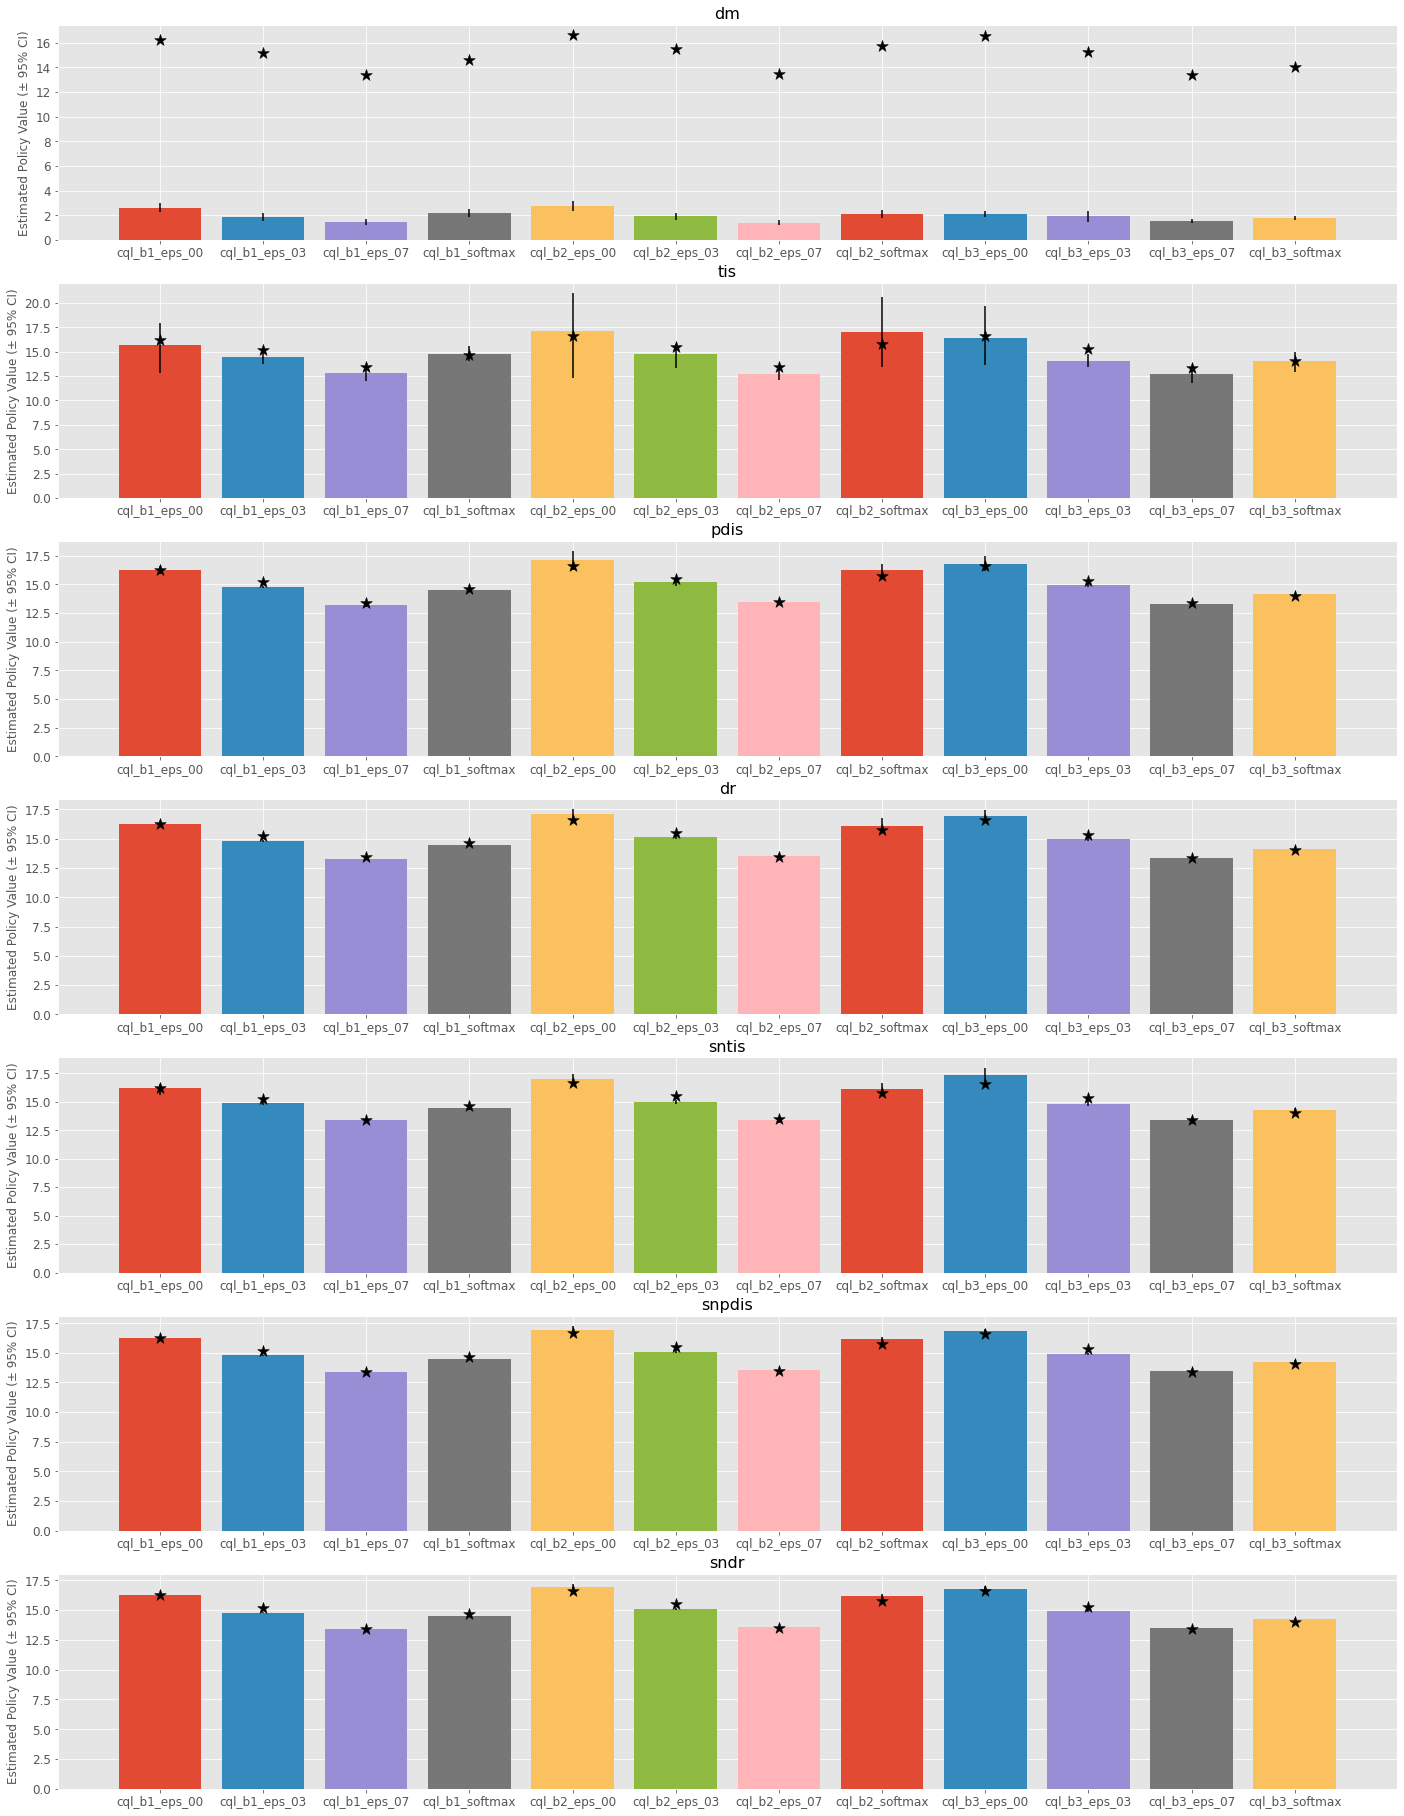

In [38]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
    random_state=random_state,
)

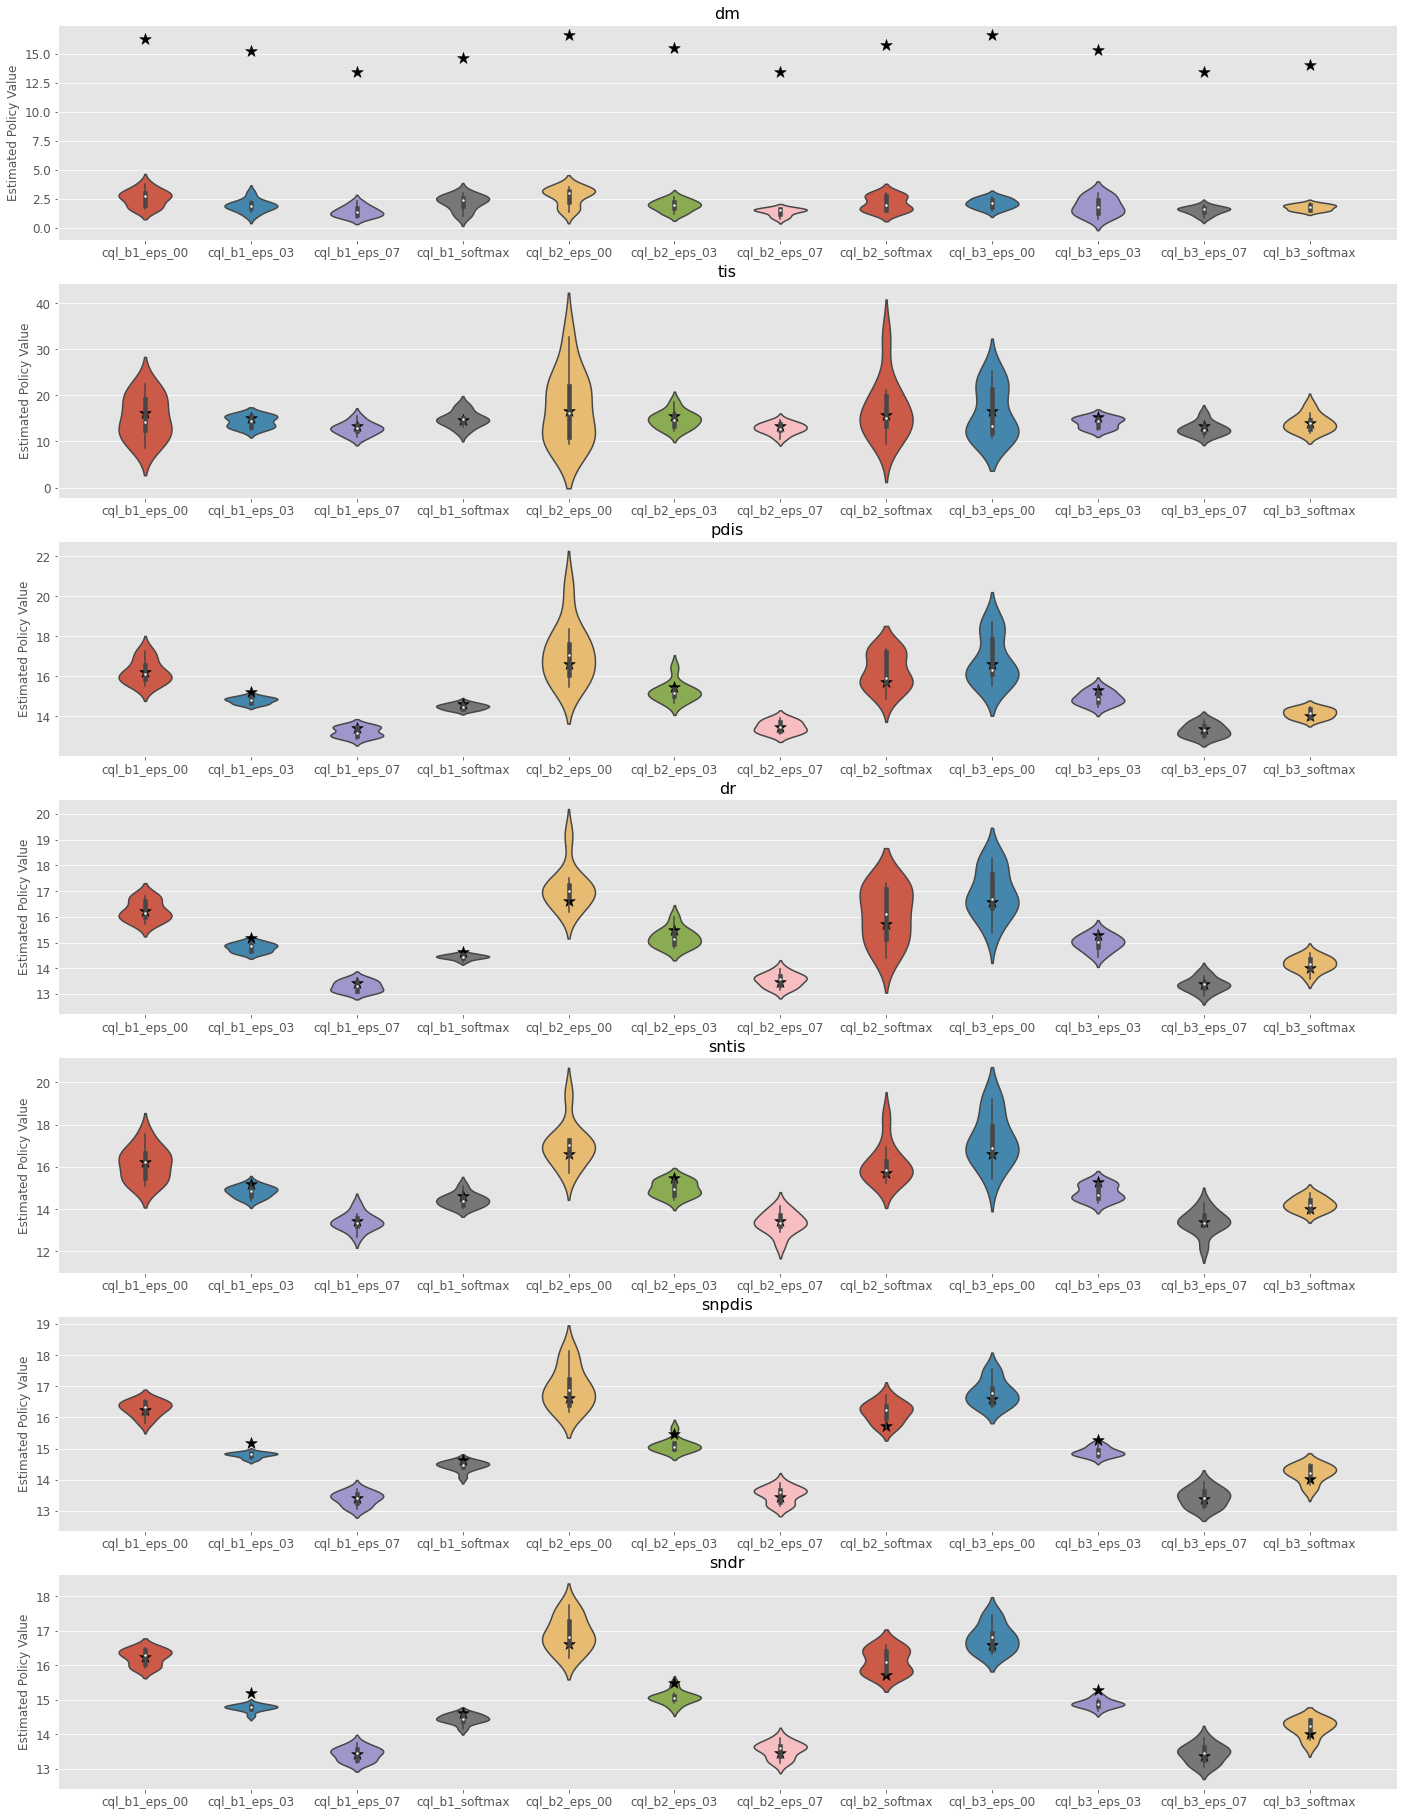

In [41]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
    random_state=random_state,
)

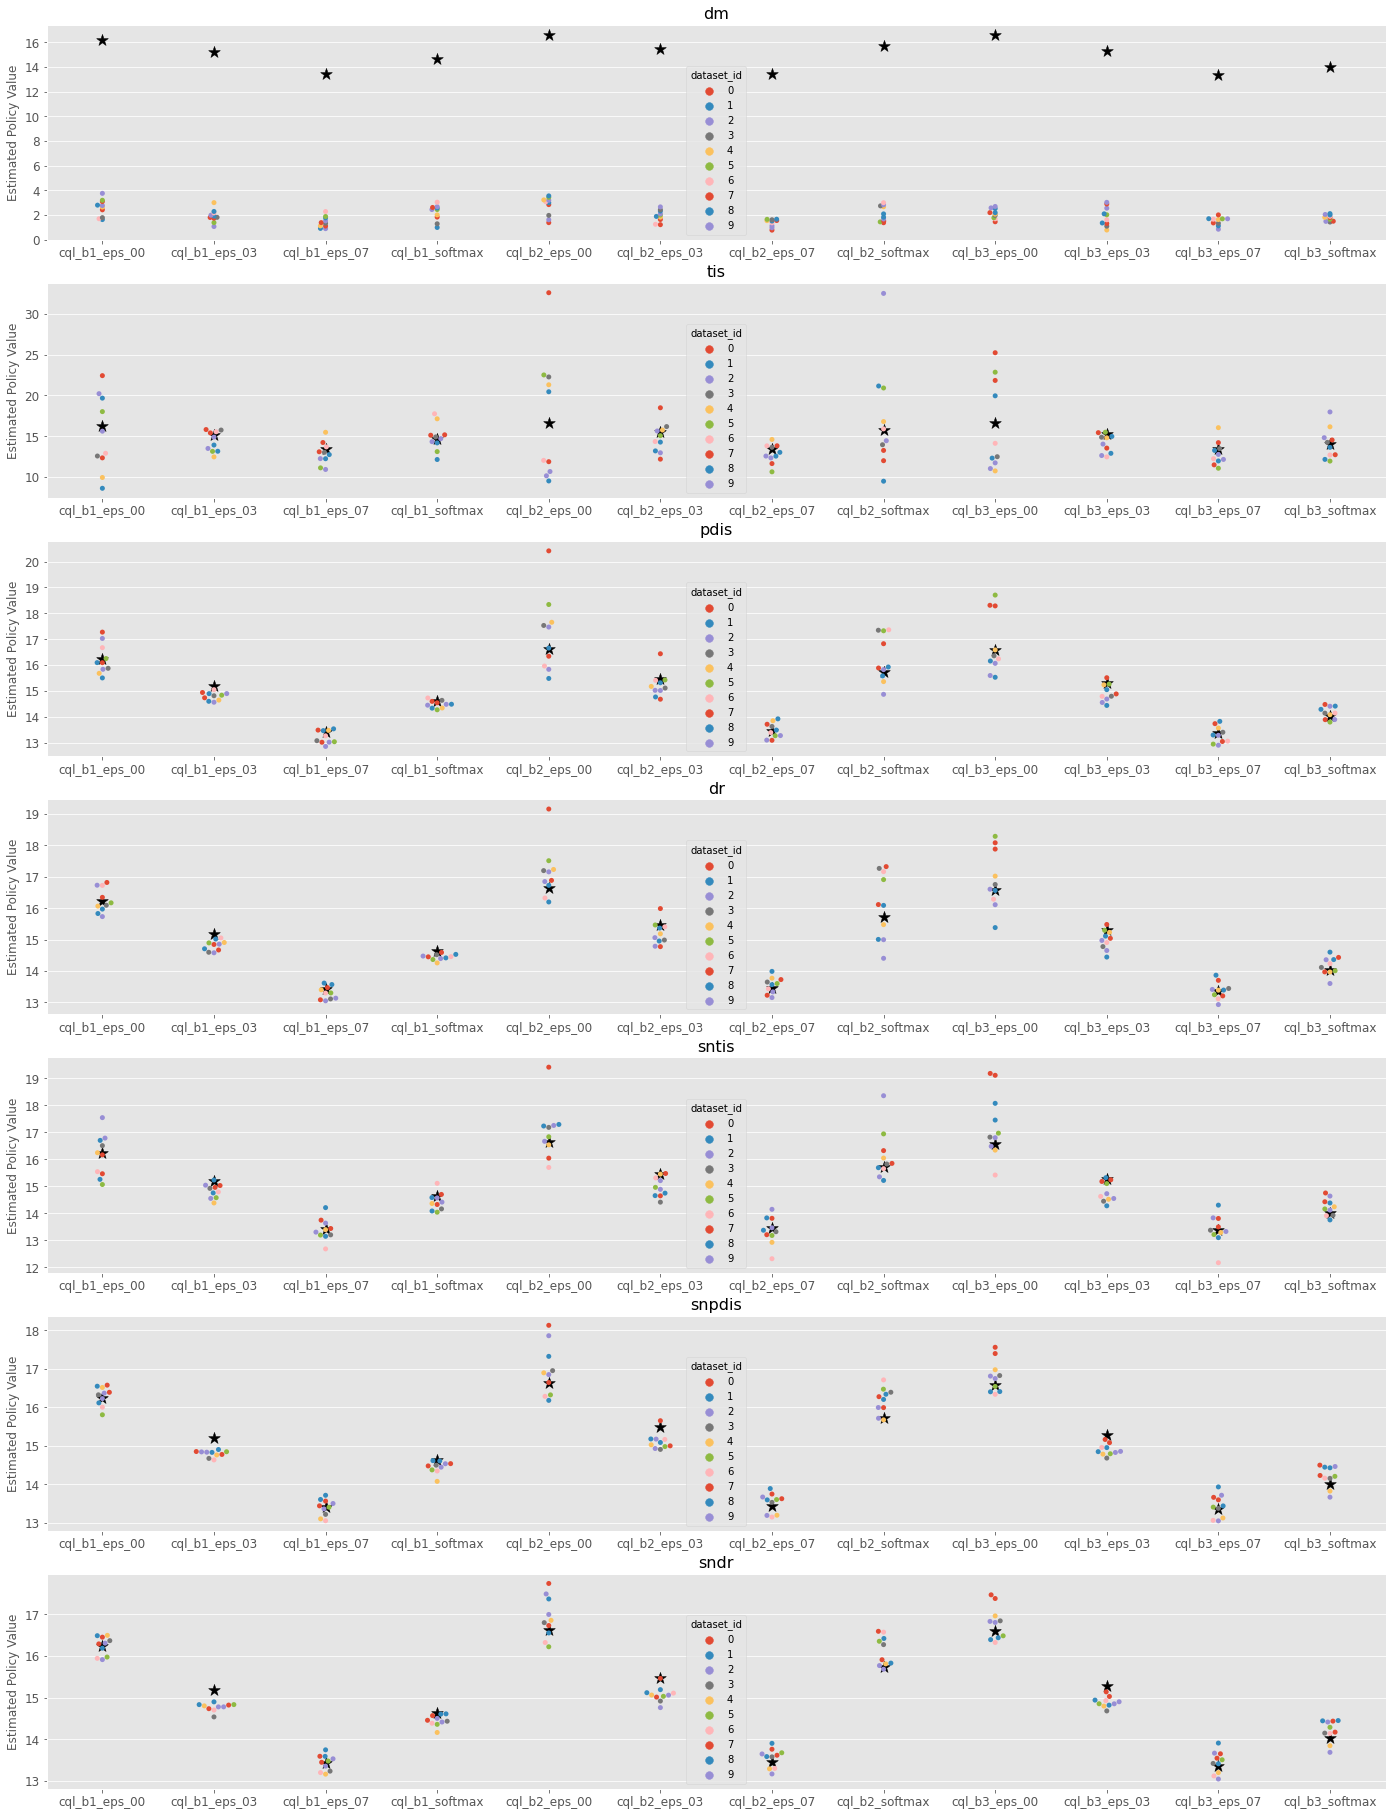

In [42]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
    random_state=random_state,
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [97]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import DiscreteCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import DiscreteCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import DiscreteCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import DiscreteCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import DiscreteCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [98]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

[0.         0.         0.         ... 0.61070185 0.61070185 0.61070185]
[4.10958904e-06 1.04109589e-04 2.04109589e-04 ... 8.64953664e-01
 8.65053664e-01 8.65153664e-01]
[3.44543615e-06 1.78025816e-03 2.16621943e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[3.20264547e-05 5.72760140e-04 9.63419556e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[0. 0. 0. ... 1. 1. 1.]
[1.e-04 2.e-04 3.e-04 ... 1.e+00 1.e+00 1.e+00]
[1.82115911e-05 1.79502431e-03 2.18098559e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[4.12912145e-08 4.13123445e-08 4.13169528e-08 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[0.         0.         0.         ... 0.65656483 0.65656483 0.65656483]
[1.00000000e-04 1.04109589e-04 2.04109589e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[1.82115911e-05 3.54365349e-04 7.40326624e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[3.10846159e-05 6.85777047e-05 3.96926403e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


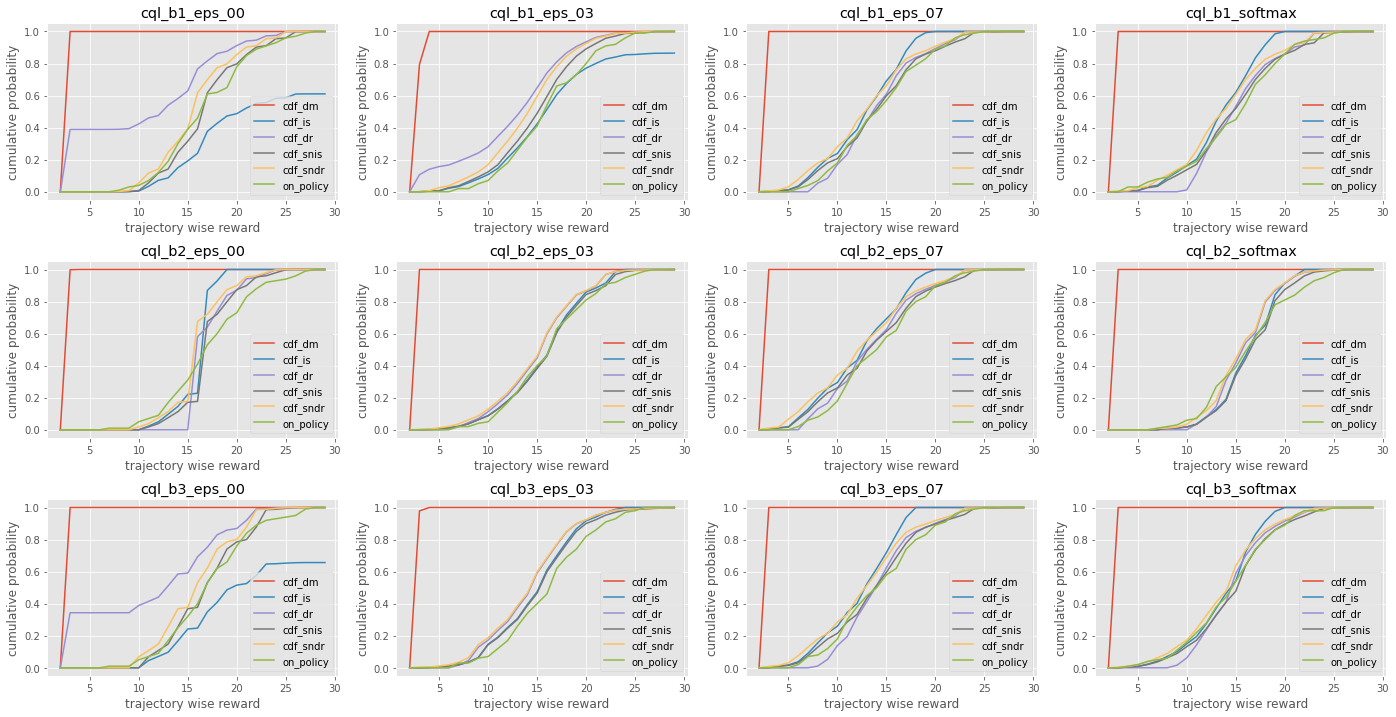

In [102]:
cd_ope.visualize_cumulative_distribution_function(
    input_dict, 
    dataset_id=4,
    n_cols=4,
)

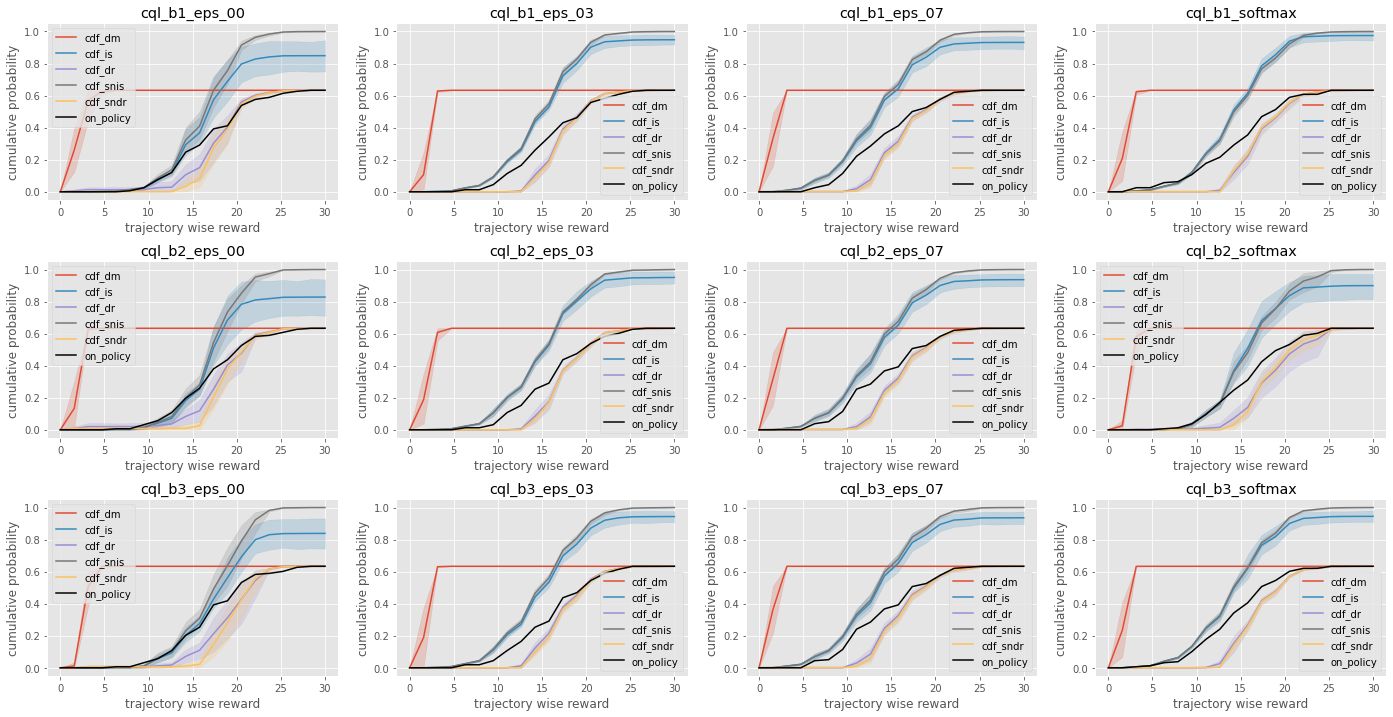

In [110]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
    n_cols=4,
)

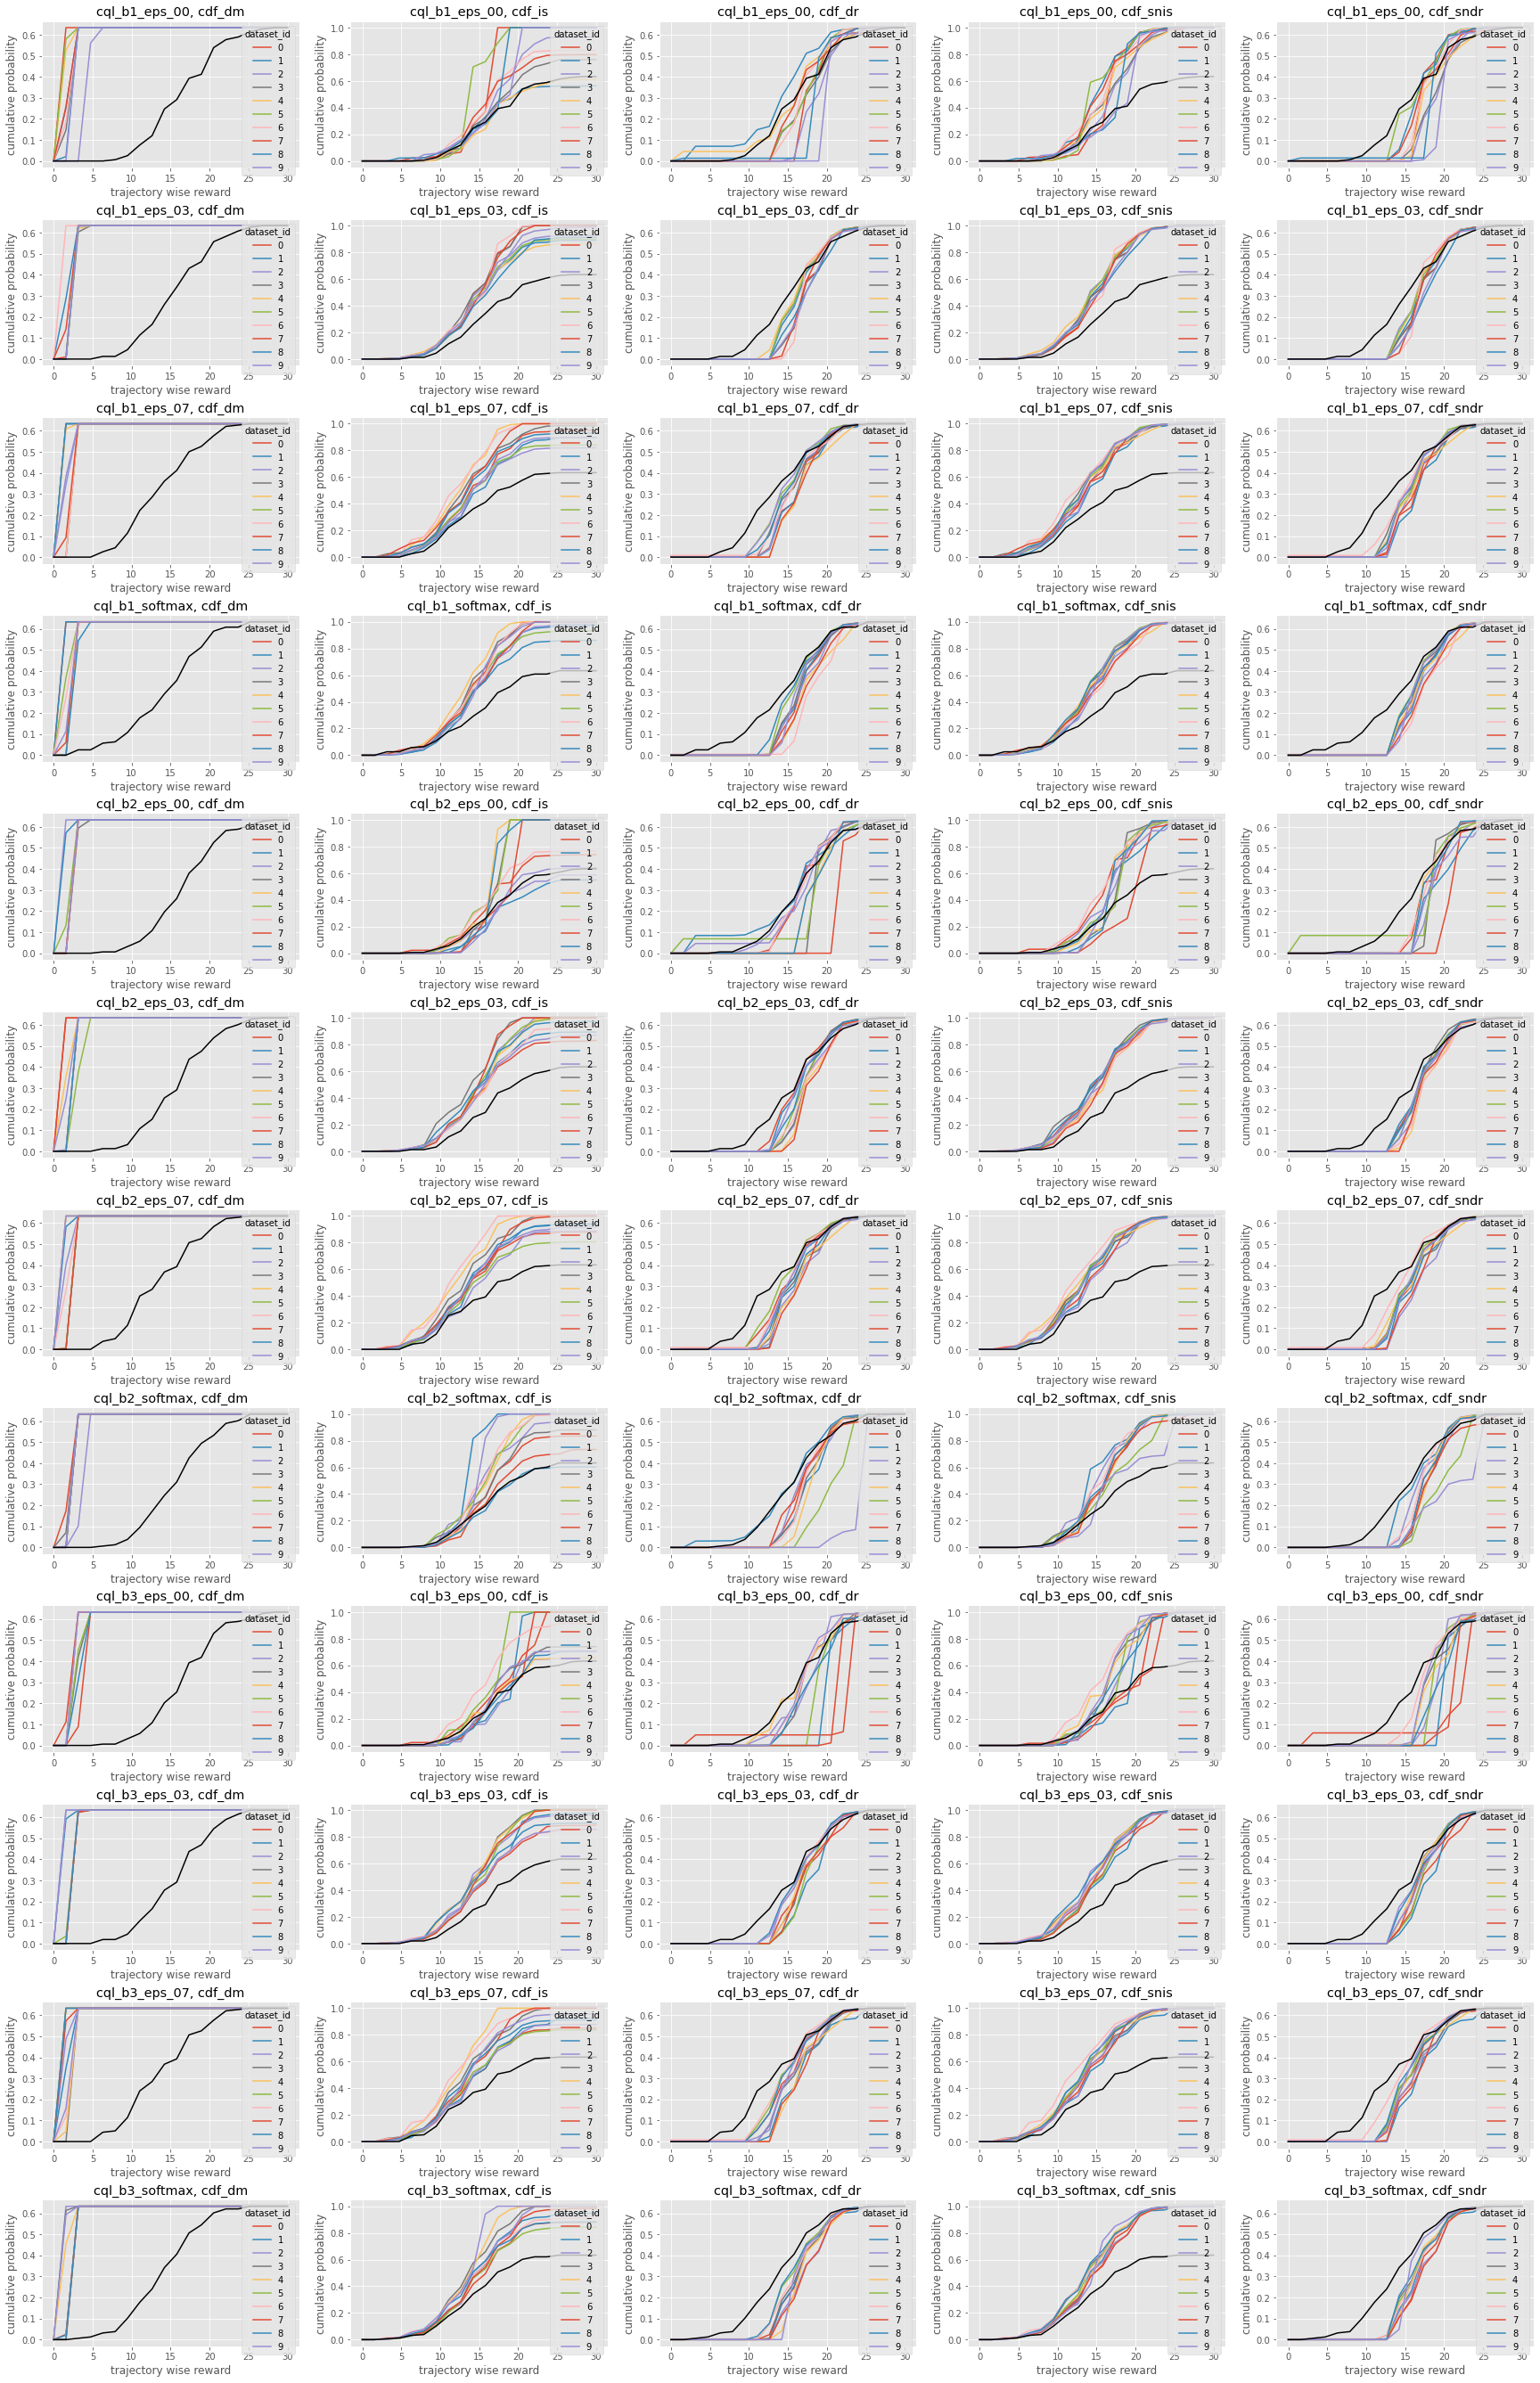

In [111]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="enumerate",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
)

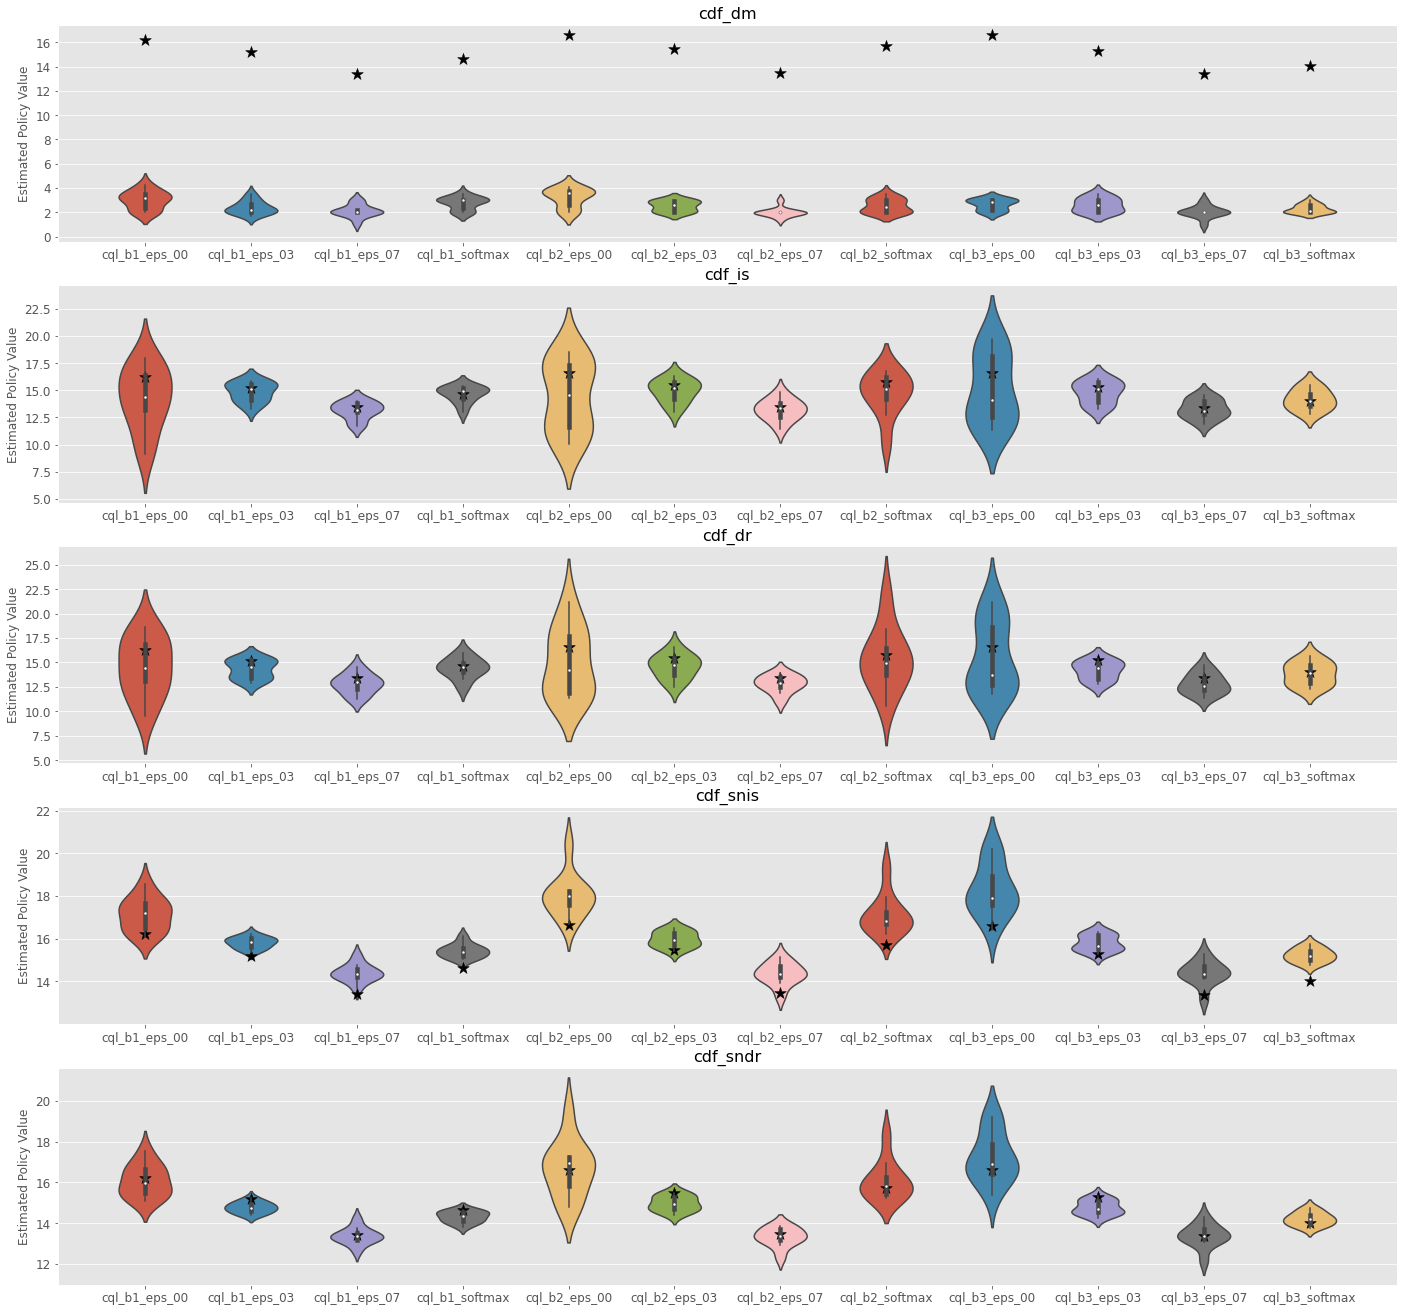

In [51]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
    random_state=random_state,
)

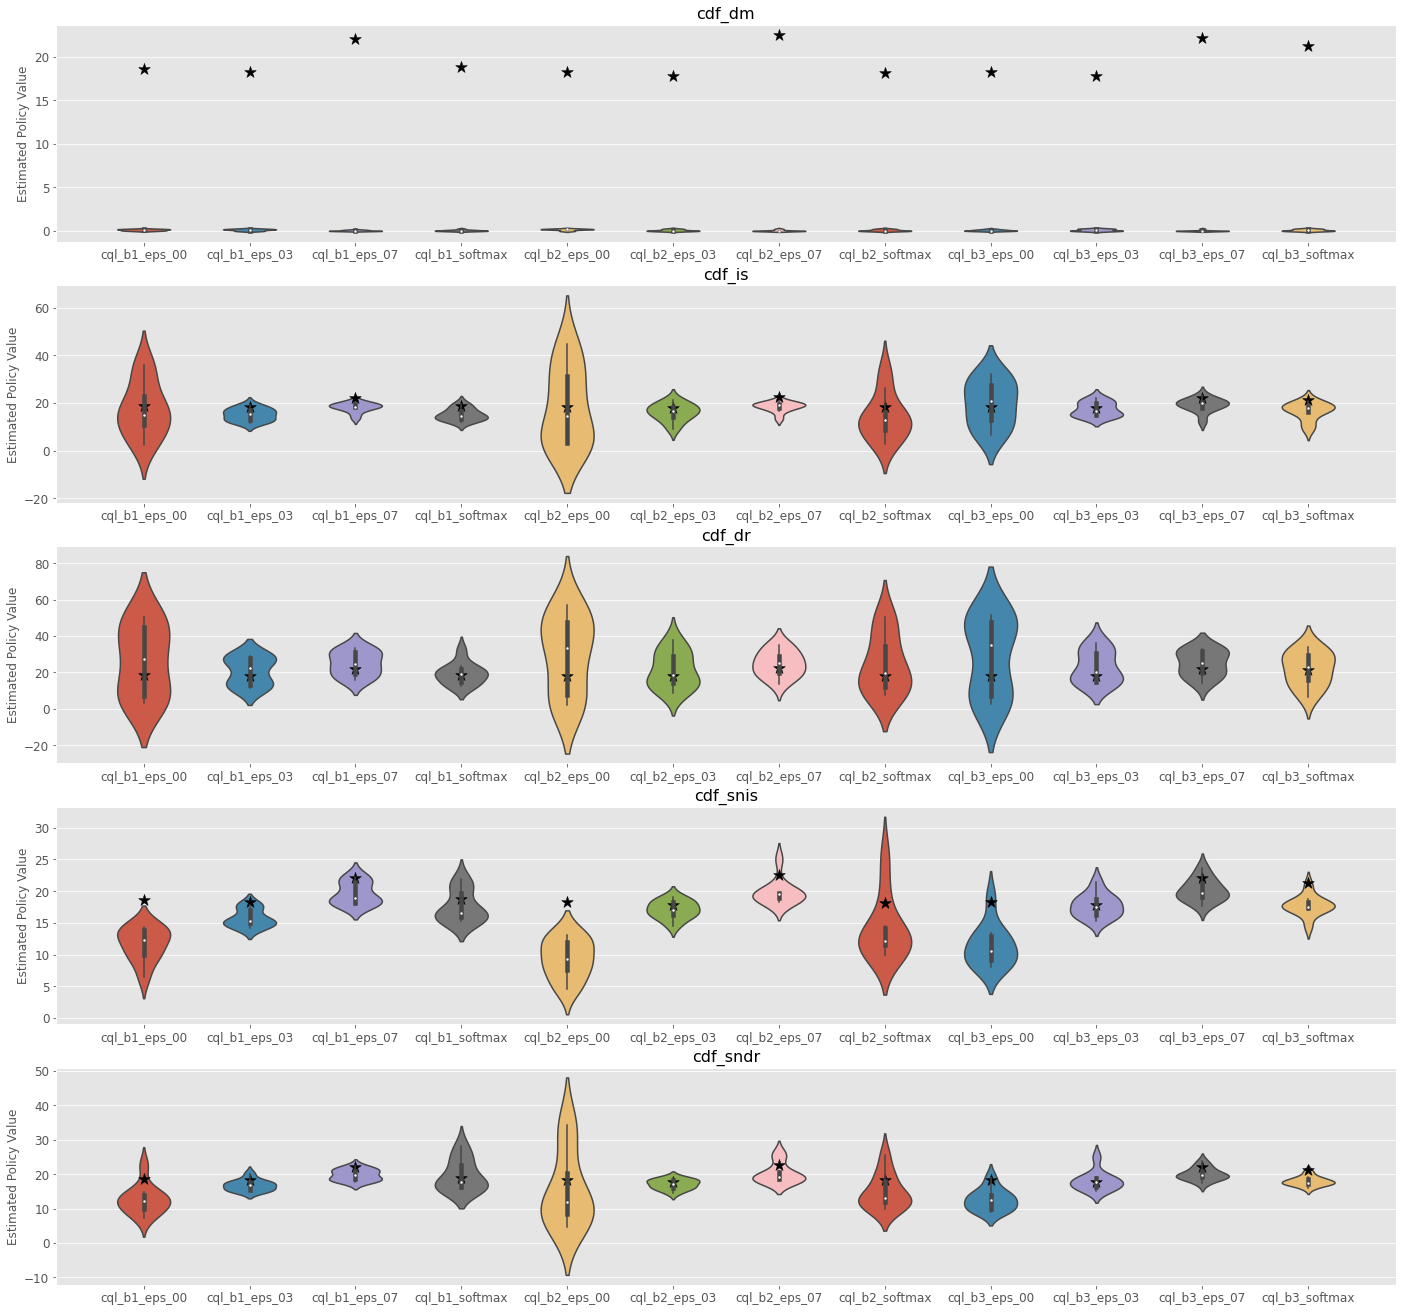

In [52]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
    random_state=random_state,
)

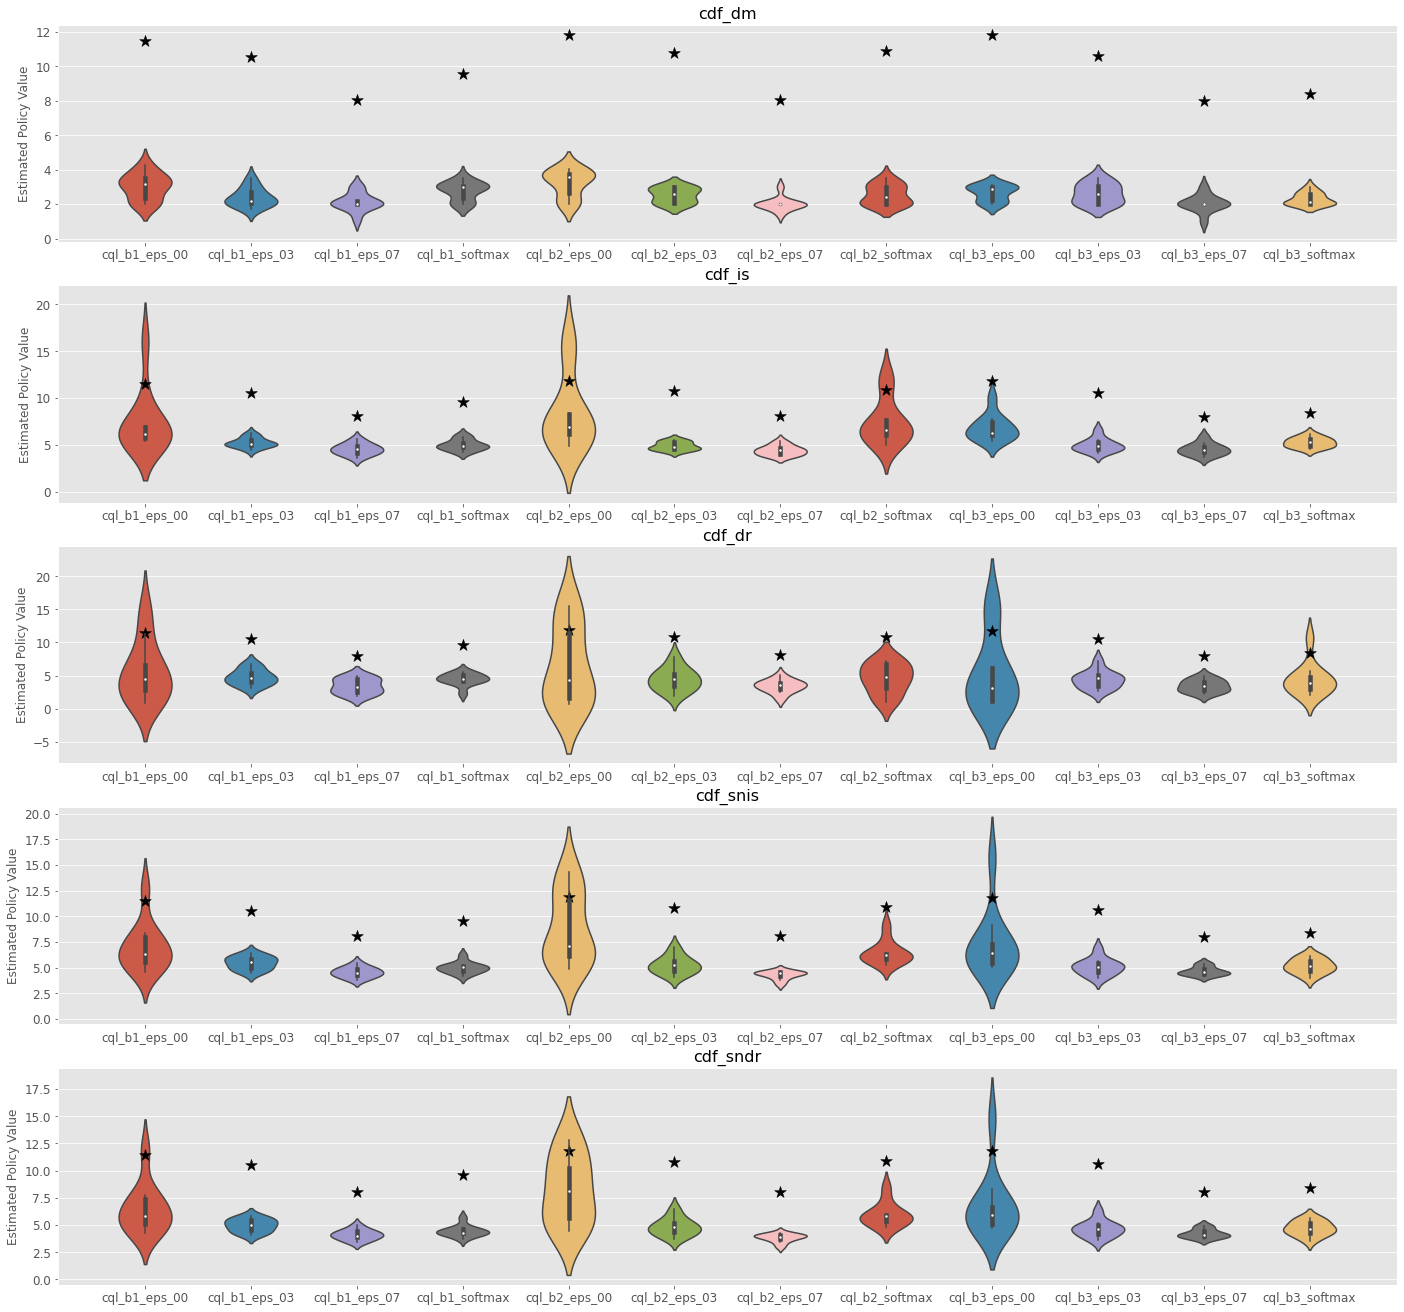

In [53]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    ope_alpha=0.3,
    plot_type="violin",
    hue="policy",
    random_state=random_state,
)

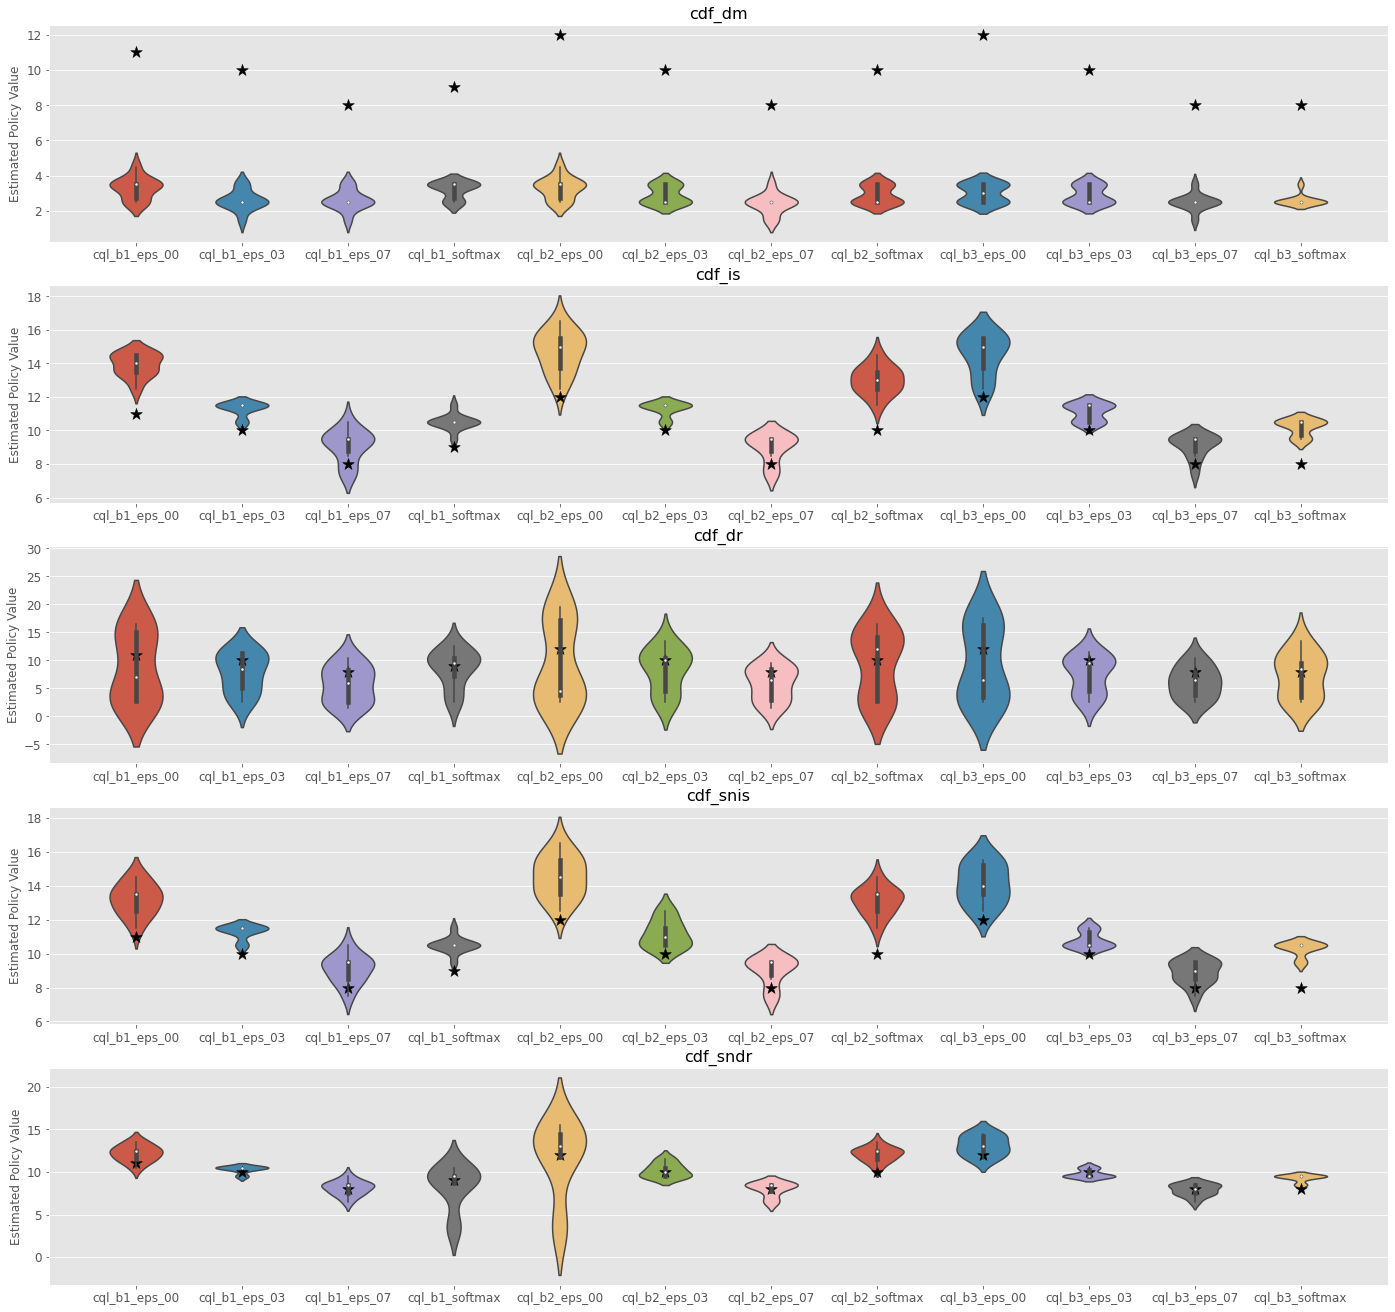

In [54]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    ope_alpha=0.1,
    plot_type="violin",
    hue="policy",
    random_state=random_state,
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [55]:
from ofrl.ope import OffPolicySelection

In [60]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [63]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result[0]

ranking  policy_value  relative_policy_value   variance  \
0    cql_b2_eps_00         16.63               1.122072  18.296061   
1    cql_b3_eps_00         16.59               1.119373  18.284747   
2    cql_b1_eps_00         16.23               1.095083  18.643535   
3   cql_b2_softmax         15.73               1.061346  18.178889   
4    cql_b2_eps_03         15.48               1.044478  17.848081   
5    cql_b3_eps_03         15.29               1.031658  17.783737   
6    cql_b1_eps_03         15.19               1.024911  18.216061   
7   cql_b1_softmax         14.63               0.987126  18.841515   
8   cql_b3_softmax         14.02               0.945968  21.272323   
9    cql_b2_eps_07         13.45               0.907508  22.553030   
10   cql_b1_eps_07         13.42               0.905484  22.003636   
11   cql_b3_eps_07         13.37               0.902111  22.154646   

   ranking_by_lower_quartile  lower_quartile  \
0              cql_b1_eps_00           10.00   
1              cql_b1_eps_03            9.95   
2              cql_b1_eps_07            9.95   
3             cql_b1_softmax            9.00   
4              cql_b2_eps_00            9.00   
5              cql_b2_eps_03            9.00   
6              cql_b2_eps_07            8.00   
7             cql_b2_softmax            7.00   
8              cql_b3_eps_00            6.00   
9              cql_b3_eps_03            5.95   
10             cql_b3_eps_07            5.95   
11            cql_b3_softmax            5.95   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                         cql_b3_eps_00                        8.4  
1                         cql_b2_eps_00                        8.4  
2                         cql_b1_eps_00                        8.4  
3                         cql_b3_eps_03                        7.8  
4                        cql_b2_softmax                        7.8  
5                         cql_b2_eps_03                        7.8  
6                         cql_b1_eps_03                        7.6  
7                        cql_b1_softmax                        5.6  
8                        cql_b3_softmax                        4.4  
9                         cql_b3_eps_07                        4.2  
10                        cql_b2_eps_07                        4.2  
11                        cql_b1_eps_07                        4.2

In [64]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [65]:
ranking_df[0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0      cql_b3_eps_03                2.895033                         0.195336   
 1      cql_b2_eps_00                2.843506                         0.191859   
 2     cql_b1_softmax                2.613440                         0.176336   
 3      cql_b1_eps_00                2.421317                         0.163373   
 4      cql_b3_eps_07                2.010809                         0.135675   
 5     cql_b3_softmax                1.802925                         0.121648   
 6      cql_b1_eps_03                1.740384                         0.117428   
 7      cql_b2_eps_07                1.553305                         0.104806   
 8      cql_b3_eps_00                1.453251                         0.098055   
 9      cql_b1_eps_07                1.384333                         0.093405   
 10    cql_b2_softmax                1.375542                         0.092812   
 11     cq

In [66]:
metric_df[0]

estimator  mean_squared_error  rank_correlation        pvalue  regret@1  \
0        dm          171.913668          0.083916  7.954145e-01      1.34   
1       tis           13.783923          0.461538  1.309481e-01      0.04   
2      pdis            0.543946          0.923077  1.862195e-05      0.04   
3        dr            0.506917          0.937063  6.993165e-06      0.04   
4     sntis            0.660698          0.930070  1.170223e-05      0.04   
5    snpdis            0.125796          0.979021  3.089801e-08      0.04   
6      sndr            0.160153          0.972028  1.286812e-07      0.04   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0  
5                0.0                 0.0  
6                0.0                 0.0

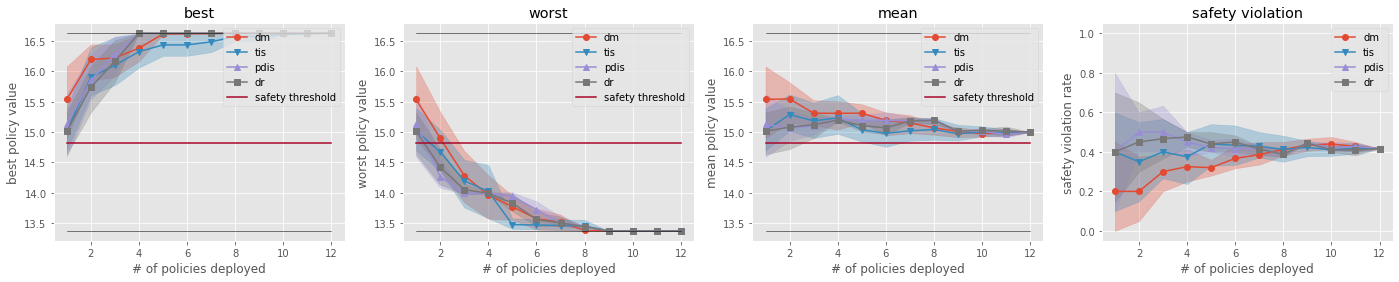

In [67]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

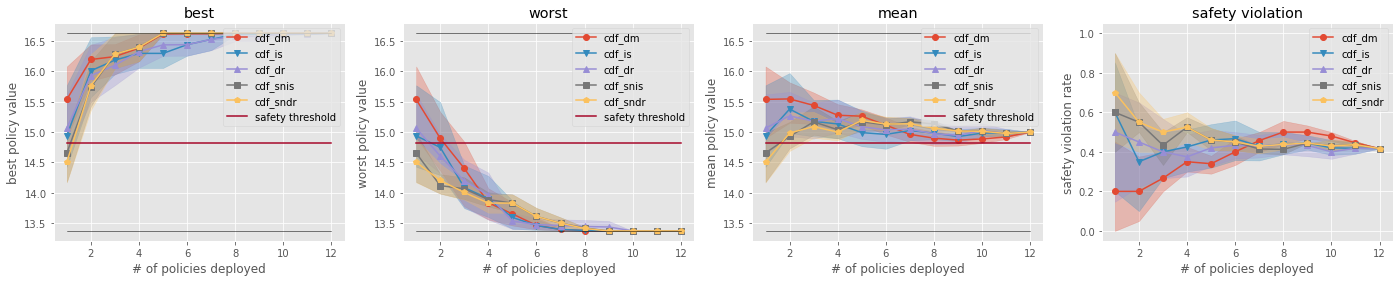

In [68]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

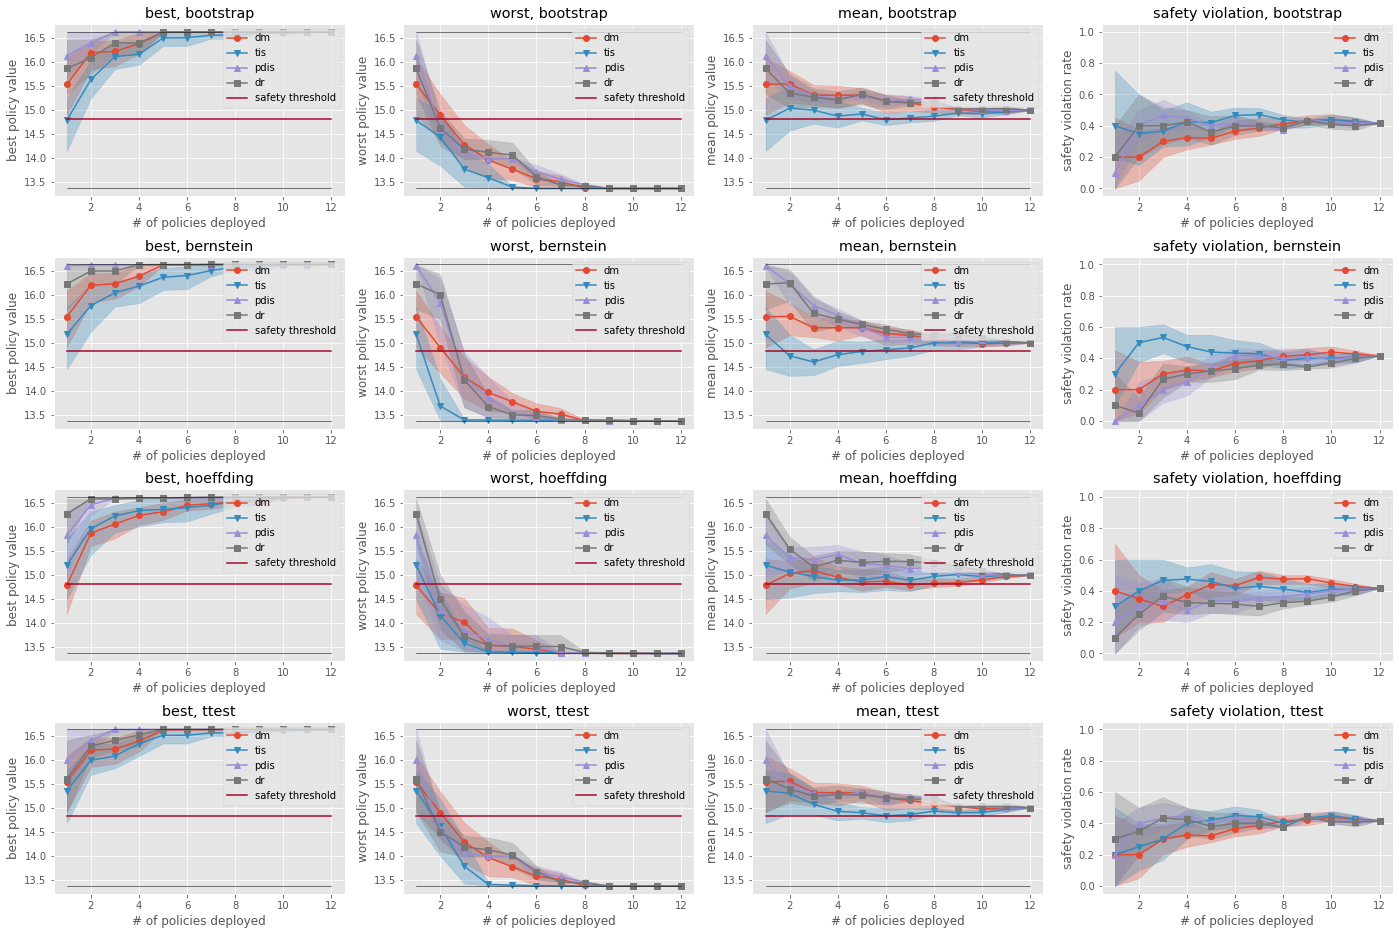

In [69]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

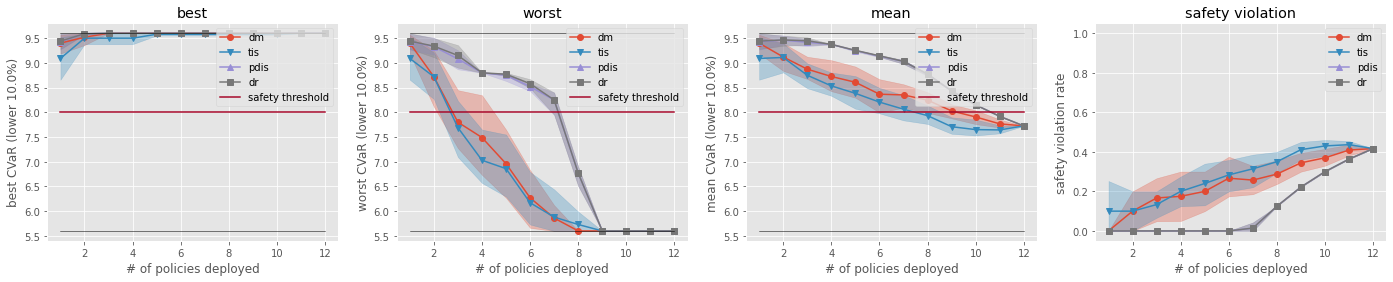

In [70]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
    random_state=random_state,
)

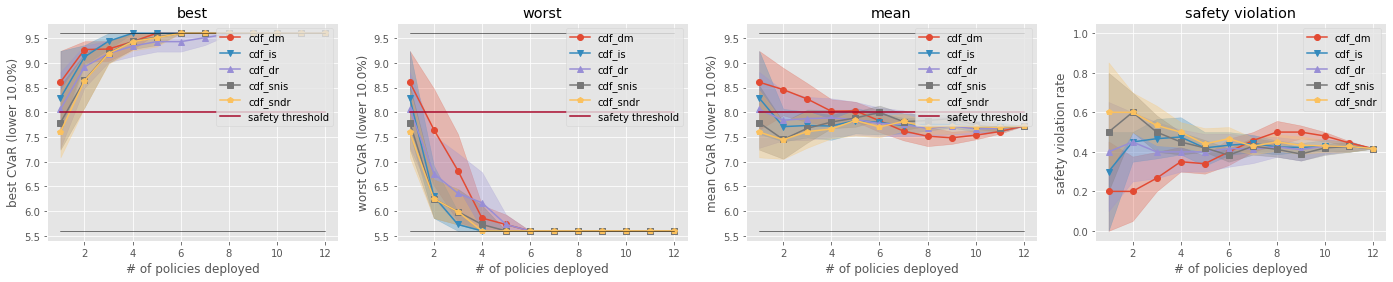

In [71]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
    random_state=random_state,
)

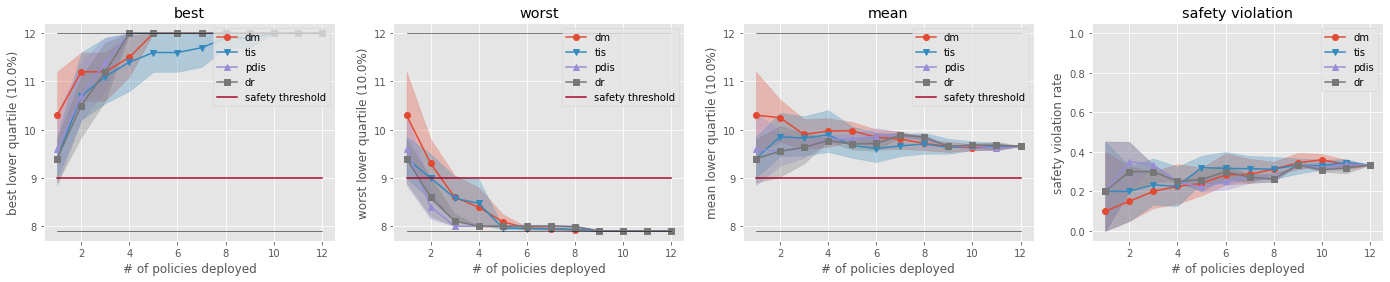

In [72]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
    random_state=random_state,
)

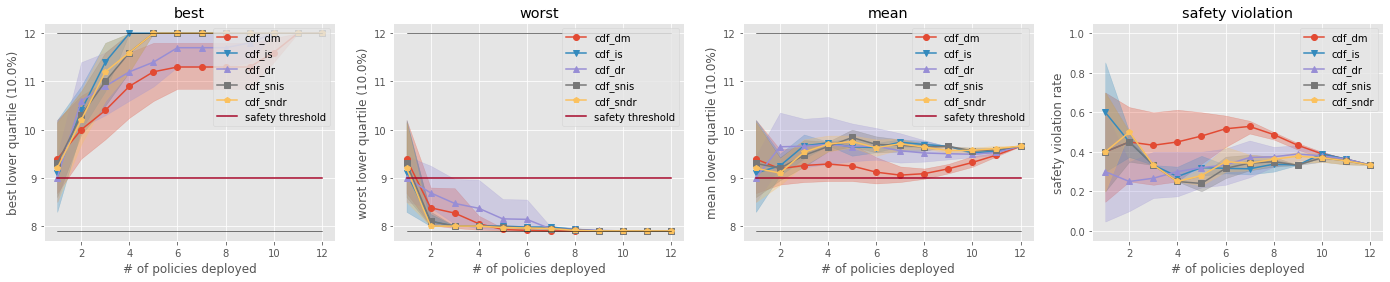

In [73]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
    random_state=random_state,
)

In [74]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

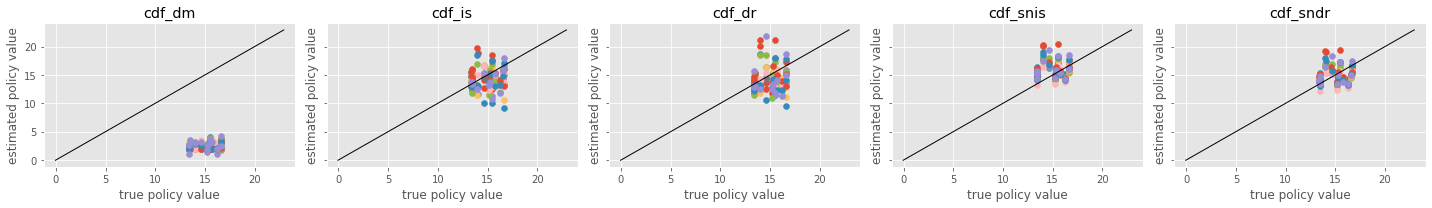

In [75]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

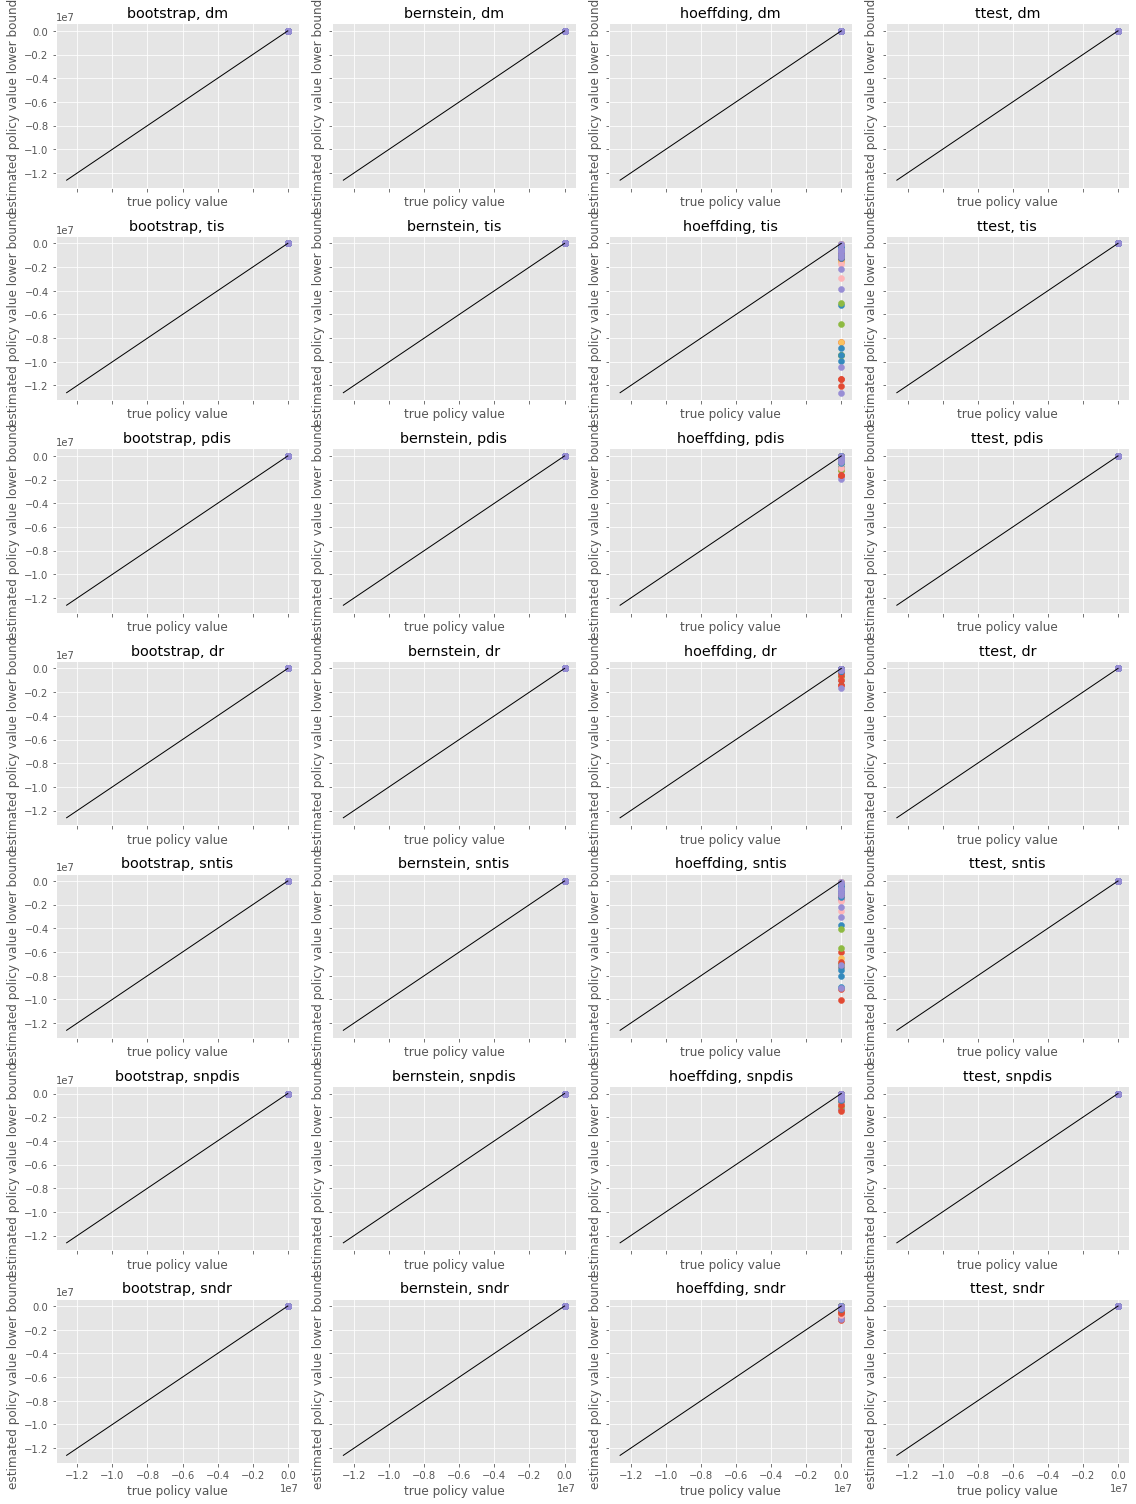

In [76]:
ops.visualize_policy_value_lower_bound_for_validation(
    input_dict=input_dict,
    cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    alpha=0.30,
    share_axes=True,
    random_state=12345,
)

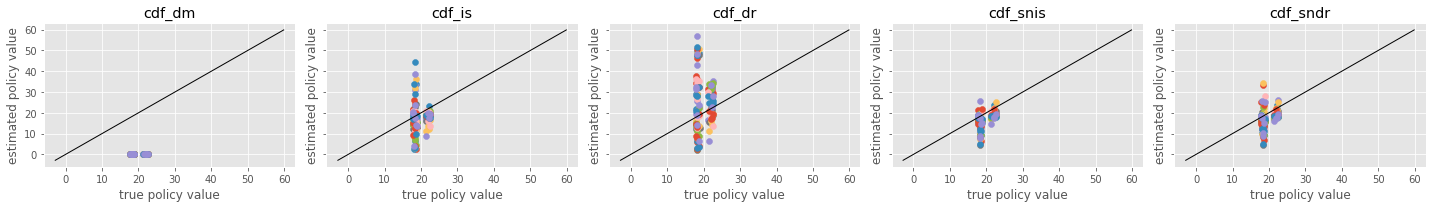

In [77]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

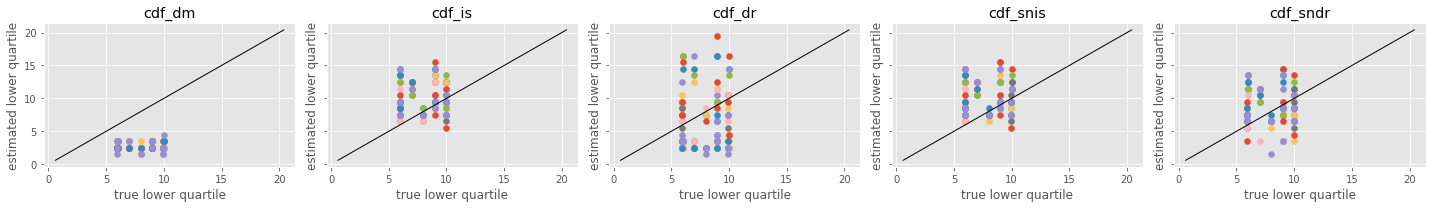

In [78]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

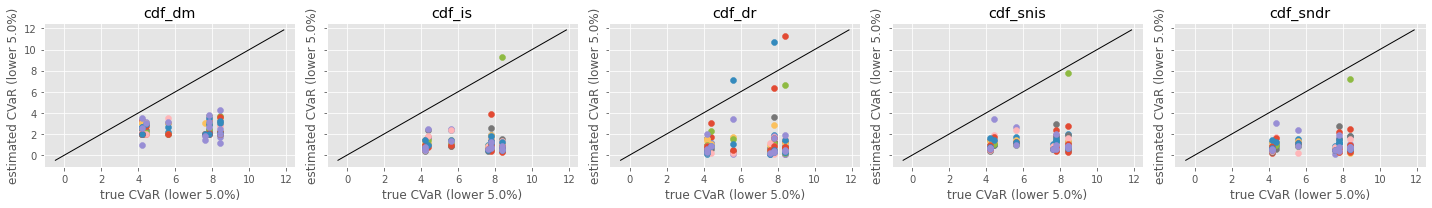

In [79]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the continuous action space, please refer to [examples/quickstart/rtb_synthetic_continuous_multiple_datasets.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.